This notebook aims at resolving the problem of this Kaggle competition submitted by Enefit:
    
https://www.kaggle.com/competitions/predict-electricity-consumption/overview

Data is assumed to be in same directory than this notebook.

I suggest you to run this notebook in Jupyter Lab and use the Table of Content for user-friendly interface :)


Jean-Baptiste Scellier. Engineer at TotalEnergies

# Data preparation

In [56]:
# Libraries for data handling and graphics
from datetime import datetime, timedelta
from math import pi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
# Loading train CSV file
train_raw = pd.read_csv("train.csv")
train_raw

time  temp  dwpt  rhum  prcp  snow   wdir  wspd  \
0     2021-09-01 00:00:00+03:00  11.2  10.3  94.0   NaN   NaN  320.0   7.2   
1     2021-09-01 01:00:00+03:00  10.7   9.6  93.0   NaN   NaN  320.0   7.2   
2     2021-09-01 02:00:00+03:00   9.9   9.0  94.0   NaN   NaN  320.0   7.2   
3     2021-09-01 03:00:00+03:00  10.0   8.4  90.0   NaN   NaN  330.0   7.2   
4     2021-09-01 04:00:00+03:00   9.0   8.1  94.0   NaN   NaN  300.0   3.6   
...                         ...   ...   ...   ...   ...   ...    ...   ...   
8587  2022-08-24 19:00:00+03:00  27.1  17.0  54.0   0.0   NaN  180.0   4.0   
8588  2022-08-24 20:00:00+03:00  25.1  17.1  61.0   0.0   NaN  220.0   6.0   
8589  2022-08-24 21:00:00+03:00  24.9  18.1  66.0   0.0   NaN  150.0   4.0   
8590  2022-08-24 22:00:00+03:00  22.1  17.0  73.0   0.0   NaN  160.0   6.0   
8591  2022-08-24 23:00:00+03:00  22.1  18.1  78.0   0.0   NaN  310.0  15.0   

      wpgt    pres  coco  el_price  consumption  
0     16.7  1012.6   2.0   0.09016        0.577  
1     13.0  1012.6   2.0   0.09251        0.594  
2     13.0  1012.2   2.0   0.08890        0.685  
3     13.0  1011.9   1.0   0.08735        1.016  
4     13.0  1011.4   2.0   0.08688        0.677  
...    ...     ...   ...       ...          ...  
8587  11.1  1020.0   2.0   0.53494        0.678  
8588  11.1  1021.0   1.0   0.49990        0.457  
8589   9.3  1020.9   4.0   0.43149        0.500  
8590   9.3  1021.0   2.0   0.55203        2.321  
8591   9.3  1021.0   2.0   0.43108        0.678  

[8592 rows x 13 columns]

In [58]:
# Load test data
test_raw = pd.read_csv("test.csv")
test_raw.head()

time  temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
0  2022-08-25 00:00:00+03:00  21.1  15.2  69.0   0.0   NaN  340.0   9.0   9.3   
1  2022-08-25 01:00:00+03:00  20.1  15.1  73.0   0.0   NaN   30.0   6.0  14.8   
2  2022-08-25 02:00:00+03:00  20.1  15.1  73.0   0.0   NaN  320.0   7.0  13.0   
3  2022-08-25 03:00:00+03:00  18.7  17.0  90.0   0.0   NaN    0.0   4.0  11.1   
4  2022-08-25 04:00:00+03:00  18.1  17.1  94.0   0.0   NaN  280.0   7.0  11.1   

     pres  coco  el_price  
0  1022.0   2.0   0.25533  
1  1022.0   2.0   0.19492  
2  1022.0   2.0   0.18853  
3  1022.4   4.0   0.19947  
4  1022.0   3.0   0.21192

In [59]:
# Drop rows in trainset where consumption is unknown
rows_to_drop = train_raw[train_raw['consumption'].isna()].index
print(train_raw.loc[rows_to_drop, 'time'])
train_raw = train_raw.drop(rows_to_drop)

1444    2021-10-31 03:00:00+02:00
4972    2022-03-27 04:00:00+03:00
Name: time, dtype: object


In [60]:
# Merge train and test for preprocessing
df_raw = pd.concat([train_raw, test_raw])

In [61]:
# Get a convenient DateTimeIndex
def add_index(data):
    data.index = pd.to_datetime(data['time'], utc=True)
    return data
df = add_index(df_raw)

In [62]:
# Get month, weekday, hour
def get_datetime_info(data):
    data['month'] = data['time'].apply(lambda x: datetime.fromisoformat(x).month)
    data['weekday'] = data['time'].apply(lambda x: datetime.fromisoformat(x).weekday())
    data['hour'] = data['time'].apply(lambda x: datetime.fromisoformat(x).hour)
    return data
df = get_datetime_info(df)

# Filling missing values

In [63]:
# Columns with missing values in trainset
train_raw.isna().sum()[train_raw.isna().sum() != 0]

prcp    6431
snow    8471
coco     196
dtype: int64

In [64]:
# Columns with missing values in testset
test_raw.isna().sum()[test_raw.isna().sum() != 0]

snow    168
dtype: int64

## Snow

In [65]:
df['original_snow'] = df['snow']

In [66]:
# Snow not NaN
df.loc[df['snow'].notna(), 'snow']

time
2021-11-08 06:00:00+00:00    10.0
2021-11-22 06:00:00+00:00     0.0
2021-11-23 06:00:00+00:00     0.0
2021-11-27 06:00:00+00:00    60.0
2021-11-28 06:00:00+00:00    70.0
                             ... 
2022-03-30 06:00:00+00:00    40.0
2022-03-31 06:00:00+00:00    20.0
2022-04-04 06:00:00+00:00    10.0
2022-04-06 06:00:00+00:00    20.0
2022-04-07 06:00:00+00:00    10.0
Name: snow, Length: 119, dtype: float64

It looks like the snow column gives the information every day at 6 am UTC about the snow depth. According to the dates, especially the months, missing days are certainly those when there was no snow at all. So we are going to add 0 on i
missing days and interpolate values from one-day to another.

In [67]:
def fill_snow(data):
    data.loc[data.index.hour == 6, 'snow'] = data.loc[data.index.hour == 6, 'snow'].fillna(0)
    data['snow'] = data['snow'].interpolate('time', limit_direction='both')
    return data
df = fill_snow(df)

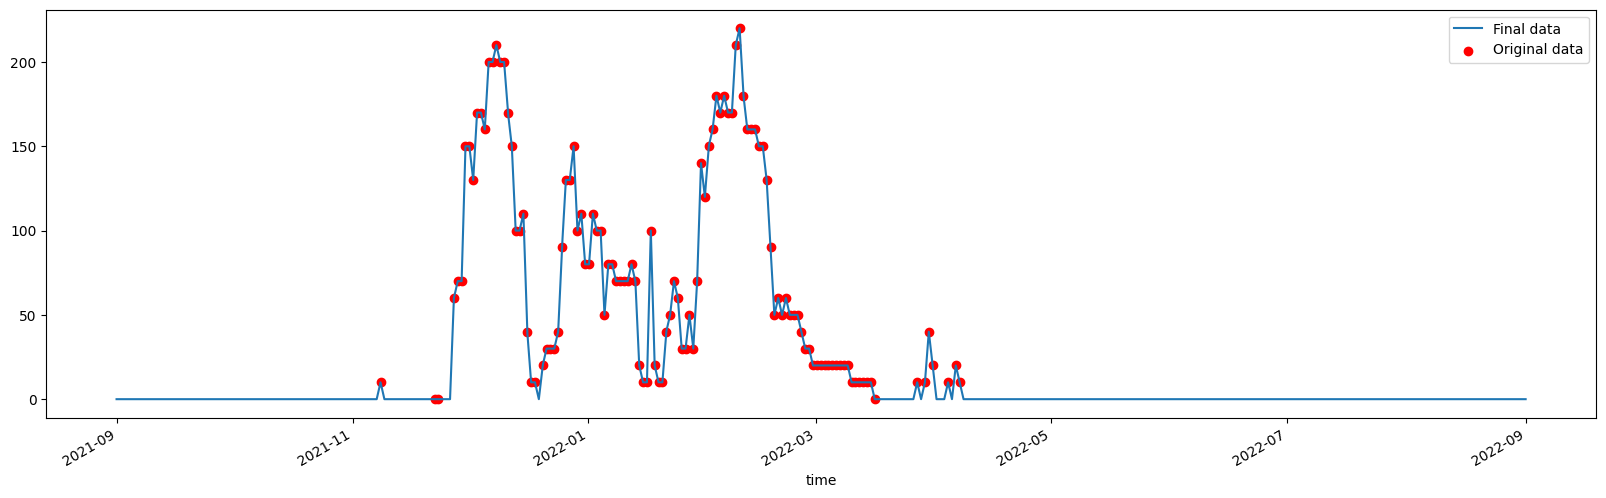

In [68]:
plt.figure(figsize=(20, 6))
df['snow'].plot(label='Final data')
plt.scatter(df['original_snow'].index, df['original_snow'].values, c='red', label="Original data")
plt.legend()
plt.show()

In [69]:
df = df.drop('original_snow', axis=1)

## Weather condition code

In [70]:
cocodic = {1: "Clear", 2: "Fair", 3: "Cloudy", 4: "Overcast", 5: "Fog",
6: "Freezing Fog", 7: "Light Rain", 8: "Rain", 9: "Heavy Rain", 10: "Freezing Rain",
11: "Heavy Freezing Rain", 12: "Sleet", 13: "Heavy Sleet", 14: "Light Snowfall", 15: "Snowfall",
16: "Heavy Snowfall", 17: "Rain Shower", 18: "Heavy Rain Shower", 19: "Sleet Shower", 20: "Heavy Sleet Shower",
21: "Snow Shower", 22: "Heavy Snow Shower", 23: "Lightning", 24: "Hail", 25: "Thunderstorm",
26: "Heavy Thunderstorm", 27: "Storm"}

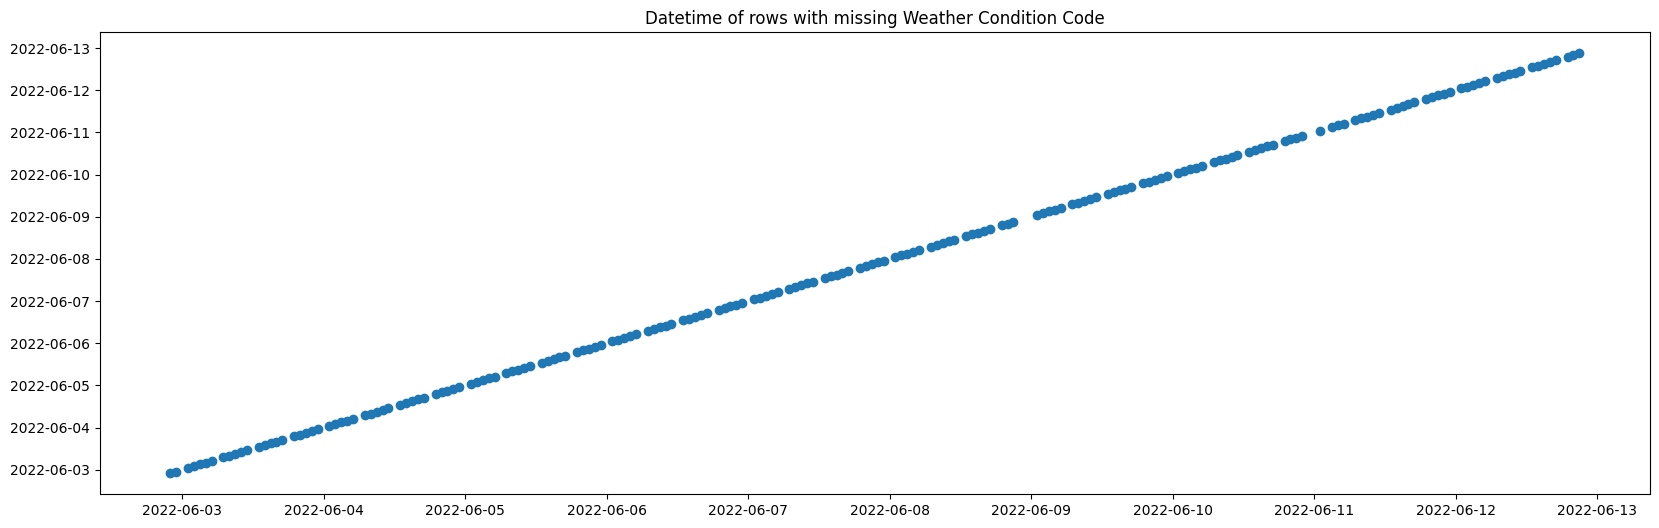

In [71]:
plt.figure(figsize=(20, 6))
plt.scatter(df.loc[df['coco'].isna()].index, df.loc[df['coco'].isna()].index)
plt.title("Datetime of rows with missing Weather Condition Code")
plt.show()

In [72]:
df.loc[df['coco'].isna(), 'time'].head(20)

time
2022-06-02 22:00:00+00:00    2022-06-03 01:00:00+03:00
2022-06-02 23:00:00+00:00    2022-06-03 02:00:00+03:00
2022-06-03 01:00:00+00:00    2022-06-03 04:00:00+03:00
2022-06-03 02:00:00+00:00    2022-06-03 05:00:00+03:00
2022-06-03 03:00:00+00:00    2022-06-03 06:00:00+03:00
2022-06-03 04:00:00+00:00    2022-06-03 07:00:00+03:00
2022-06-03 05:00:00+00:00    2022-06-03 08:00:00+03:00
2022-06-03 07:00:00+00:00    2022-06-03 10:00:00+03:00
2022-06-03 08:00:00+00:00    2022-06-03 11:00:00+03:00
2022-06-03 09:00:00+00:00    2022-06-03 12:00:00+03:00
2022-06-03 10:00:00+00:00    2022-06-03 13:00:00+03:00
2022-06-03 11:00:00+00:00    2022-06-03 14:00:00+03:00
2022-06-03 13:00:00+00:00    2022-06-03 16:00:00+03:00
2022-06-03 14:00:00+00:00    2022-06-03 17:00:00+03:00
2022-06-03 15:00:00+00:00    2022-06-03 18:00:00+03:00
2022-06-03 16:00:00+00:00    2022-06-03 19:00:00+03:00
2022-06-03 17:00:00+00:00    2022-06-03 20:00:00+03:00
2022-06-03 19:00:00+00:00    2022-06-03 22:00:00+03:00
2022-

In [73]:
#def drop_coco(data):
#    data = data.dropna(subset='coco')
#    return data
#df = drop_coco(df)

All rows with missing values are in begin of June. And there is kind of a pattern with maximum 5 consecutive hours with missing values. I will assume that most probable weather is the weather of the closest datetime.

In [74]:
df['coco'] = df['coco'].interpolate('nearest', limit=3, limit_direction='both')
len(df[df['coco'].isna()])

0

# Visualisation

## Consumption

### Time series

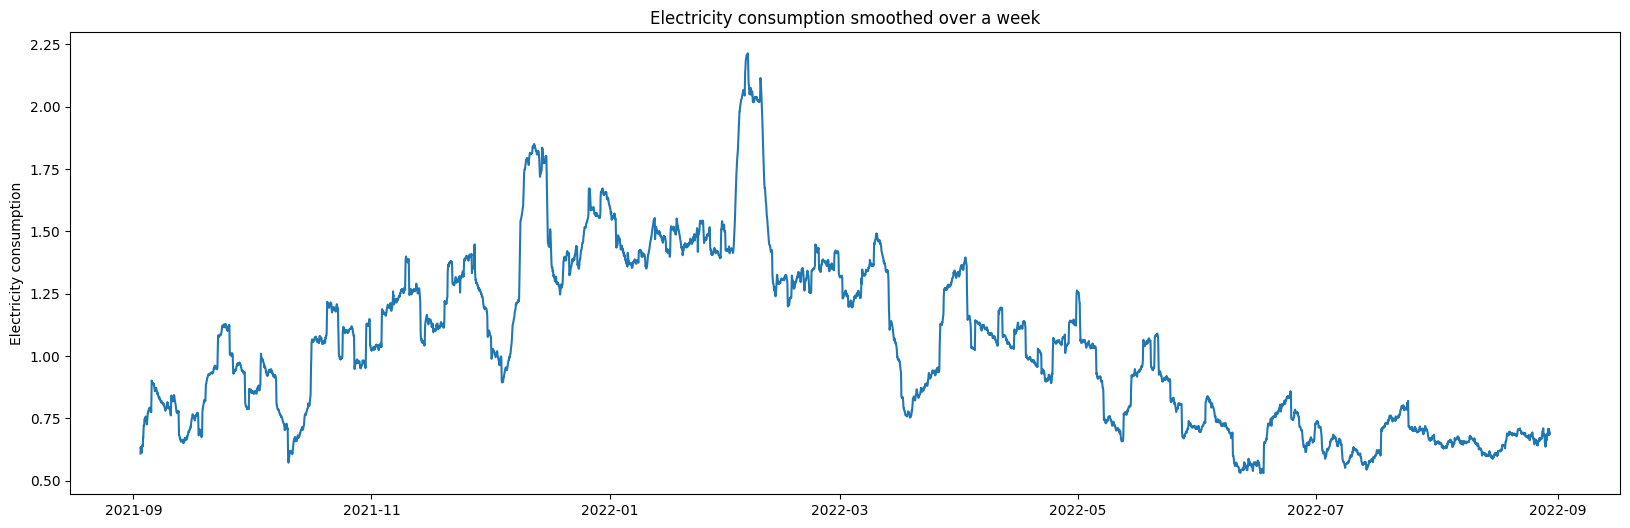

In [75]:
plt.figure(figsize=(20, 6))
plt.ylabel("Electricity consumption")
plt.title("Electricity consumption smoothed over a week")
plt.plot(df['consumption'].rolling(timedelta(days=7), min_periods=48).mean())
plt.show()

We see a seasonal trend with a peak in winter and a down in summer.

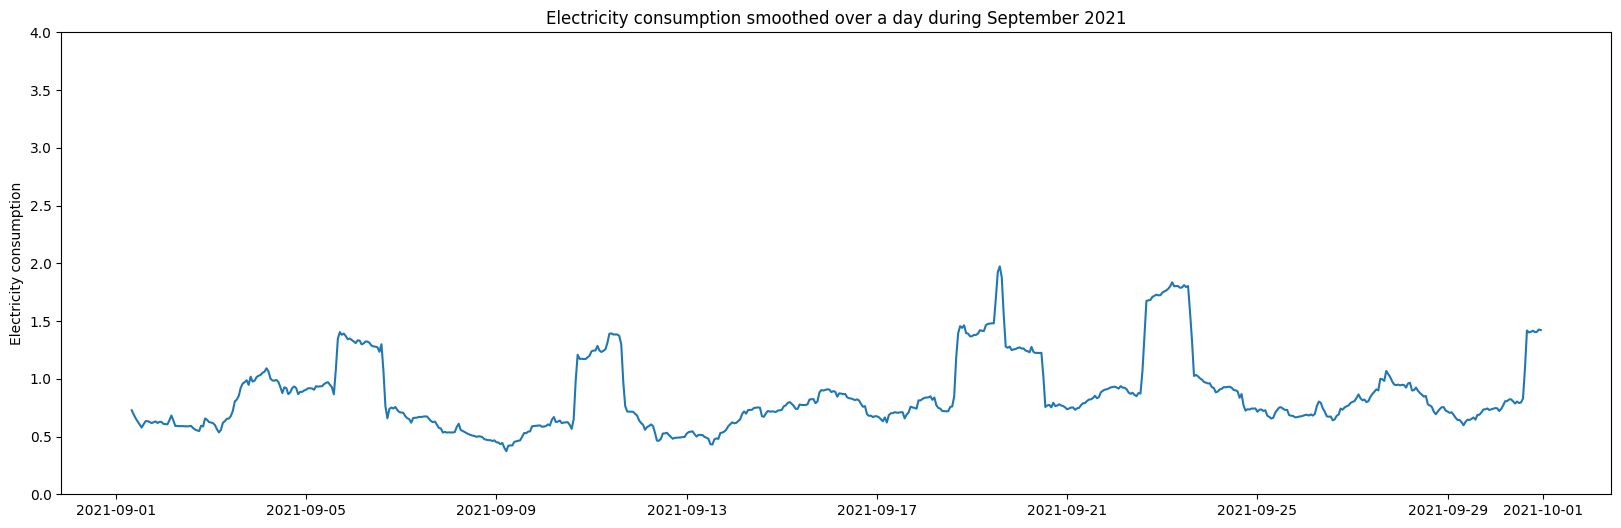

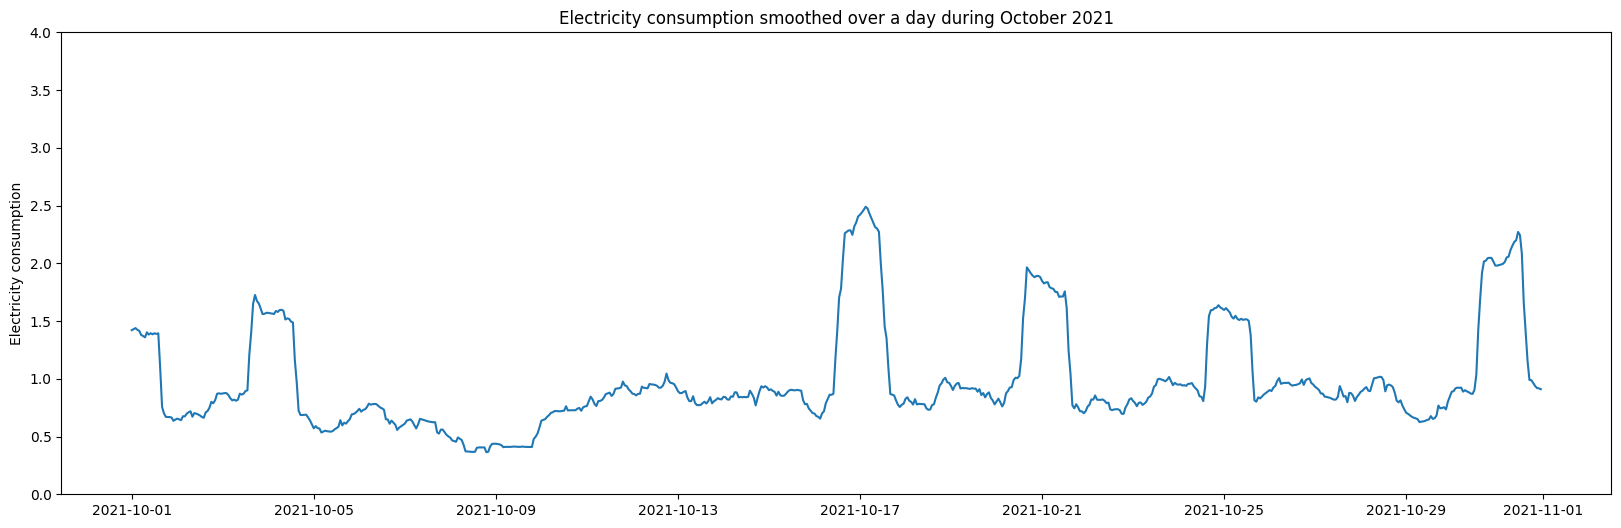

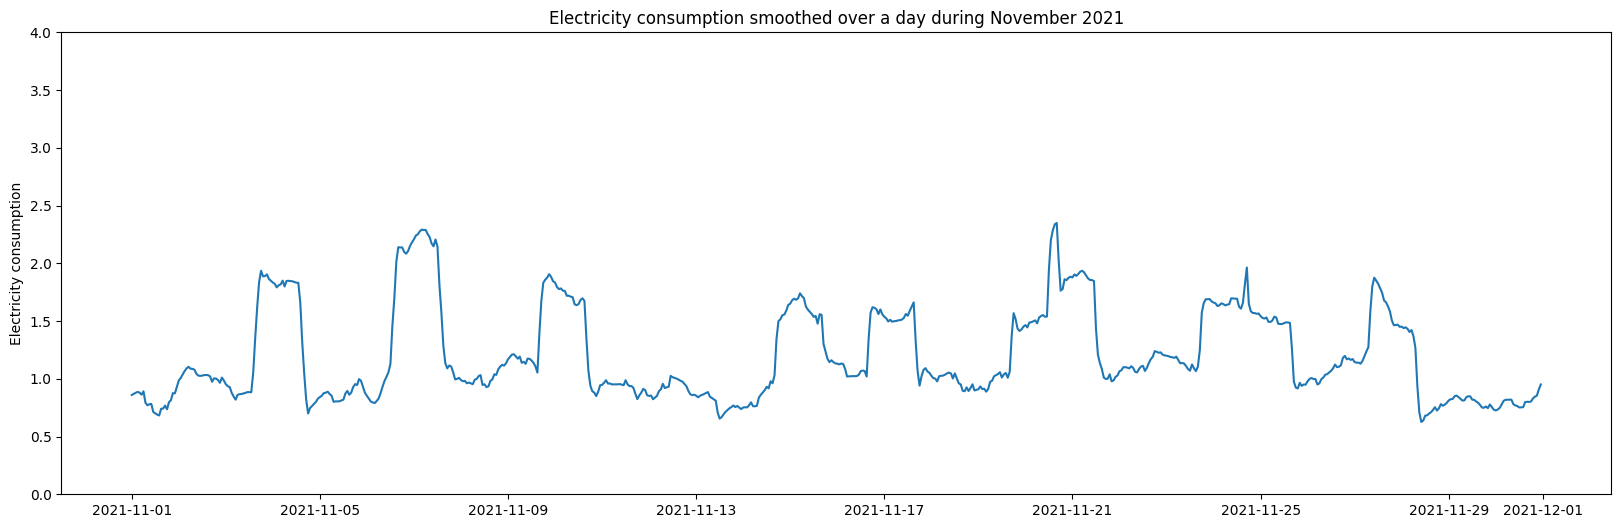

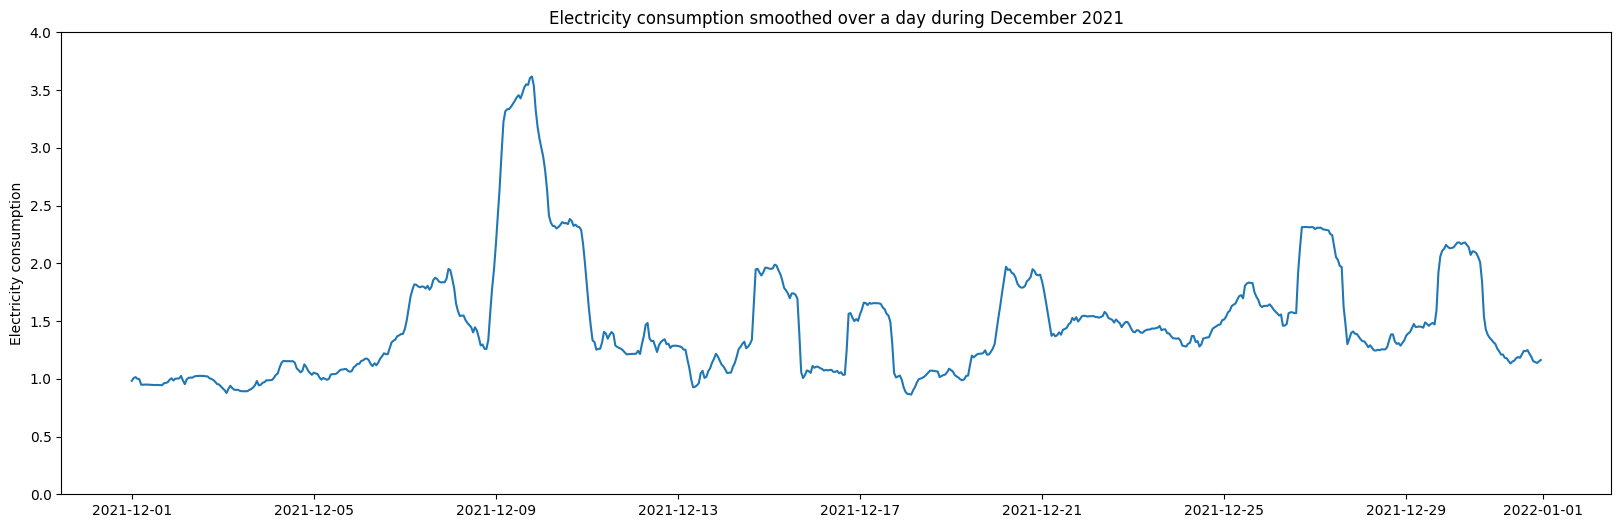

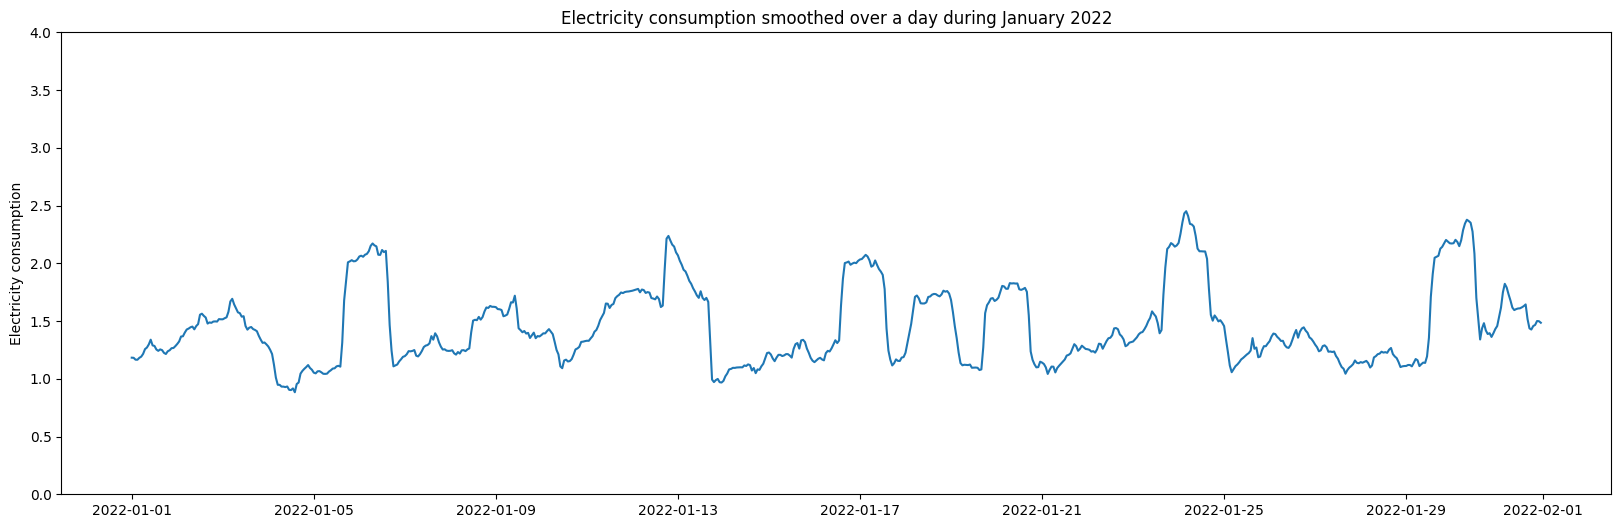

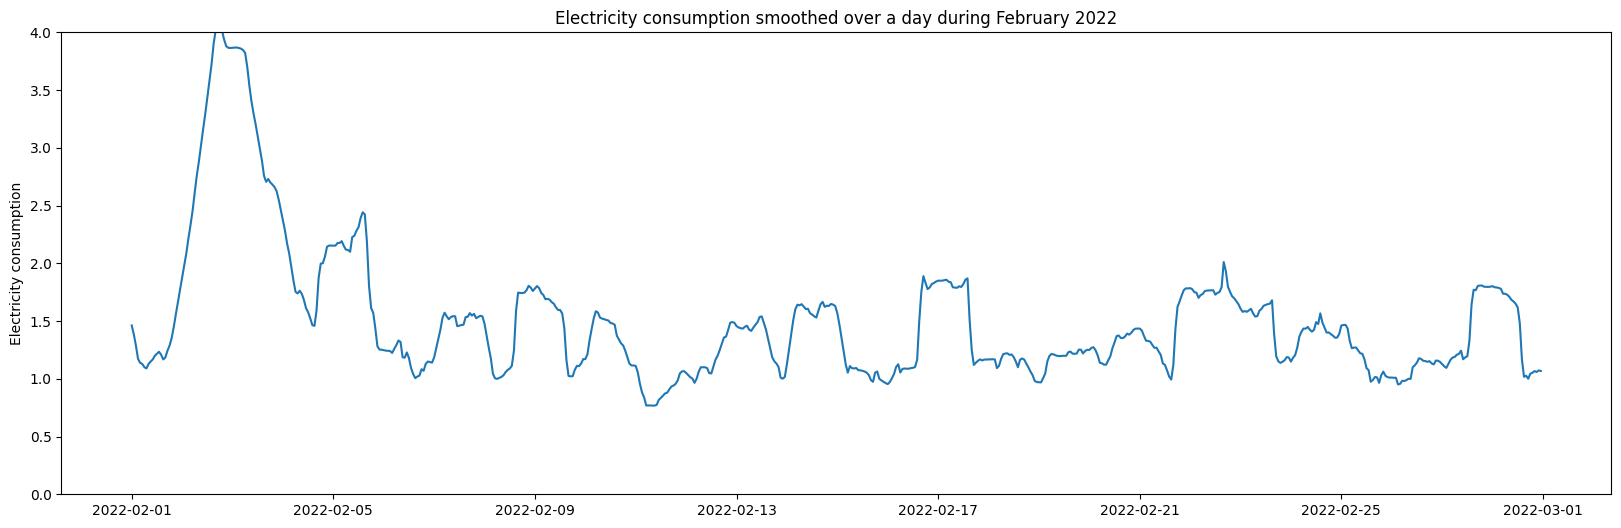

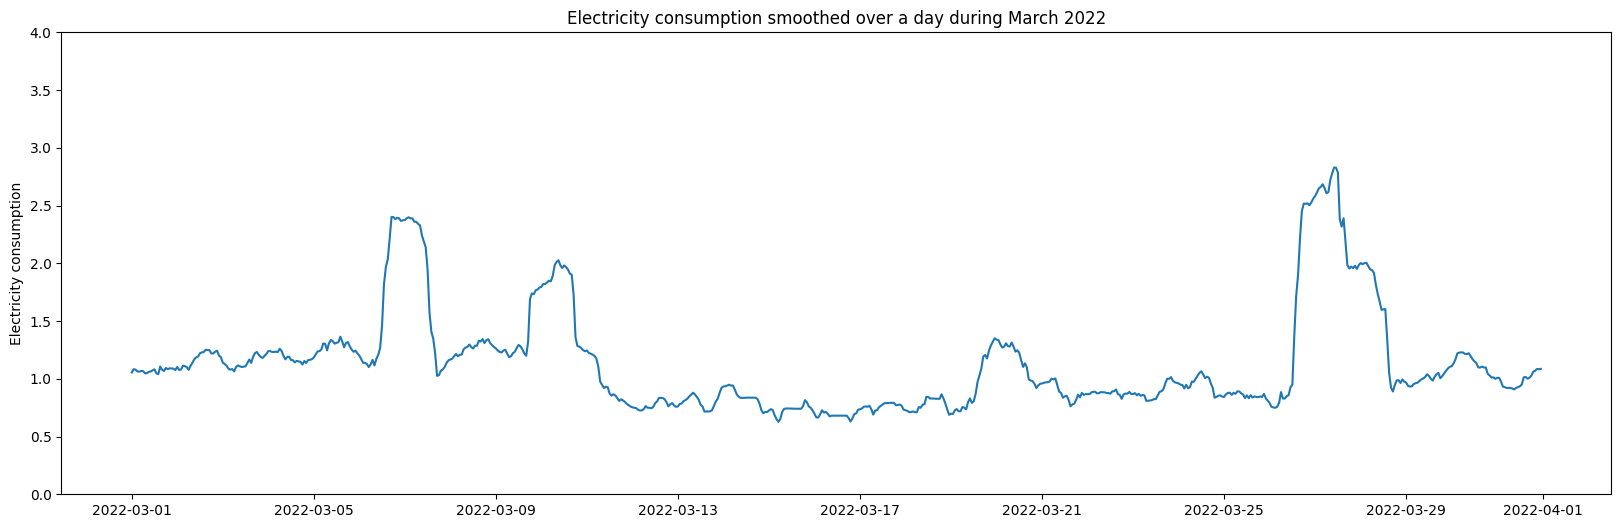

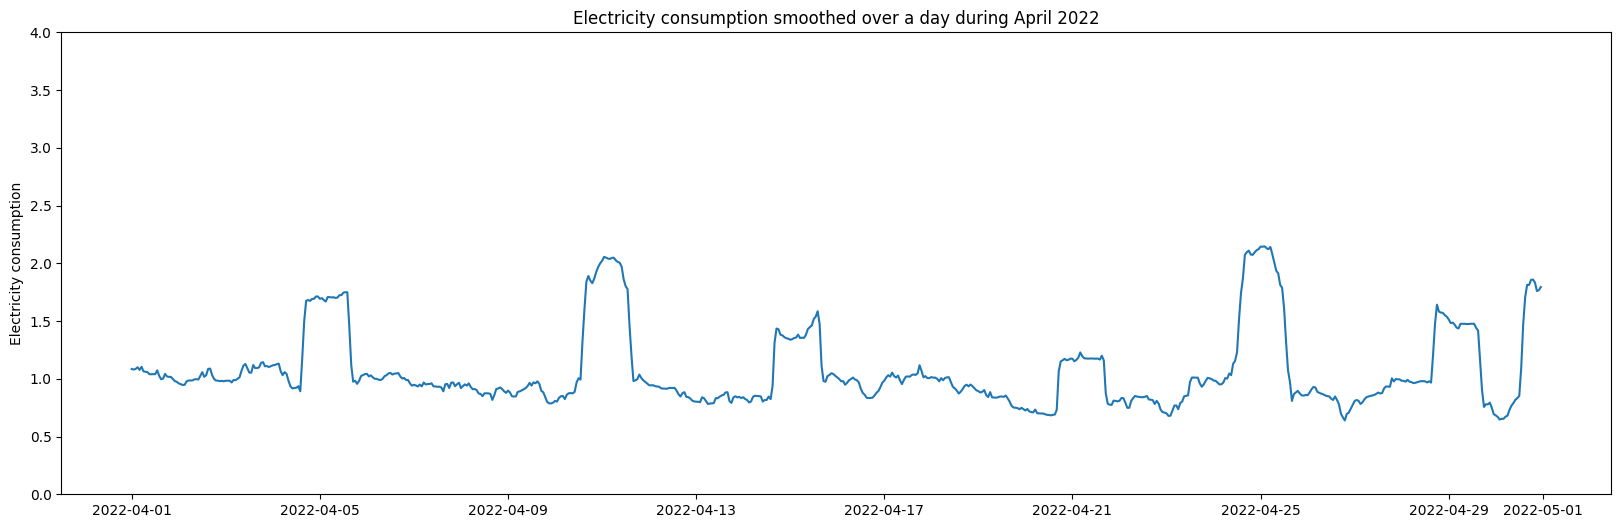

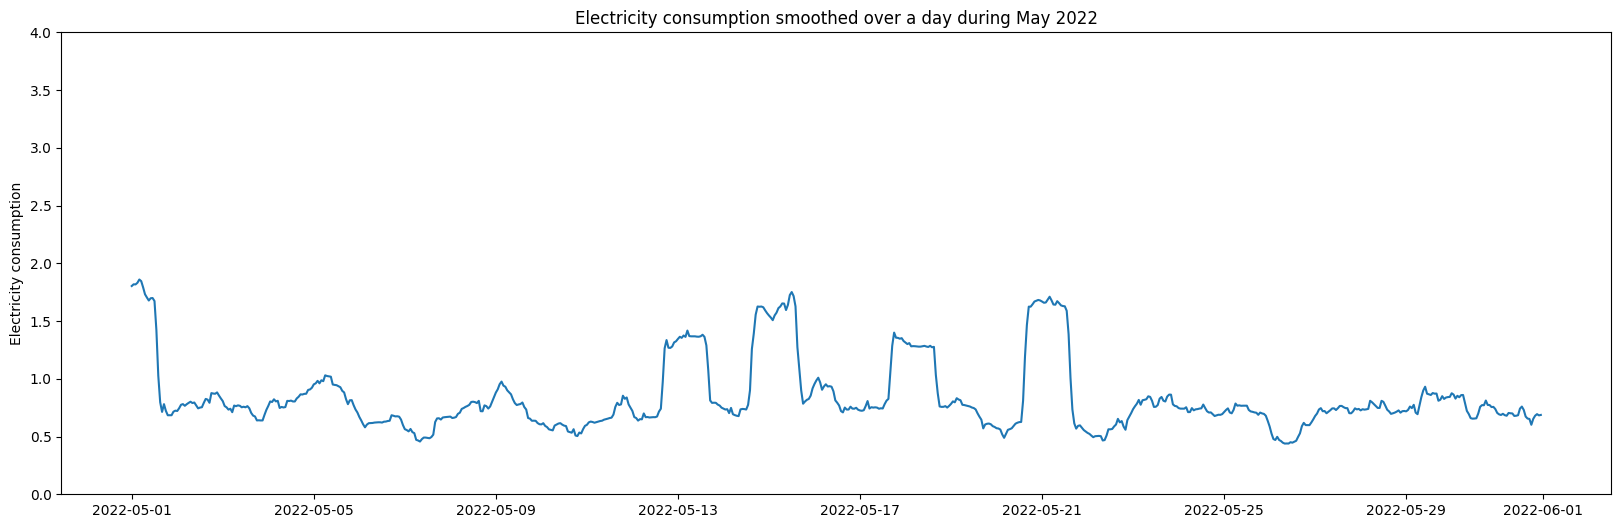

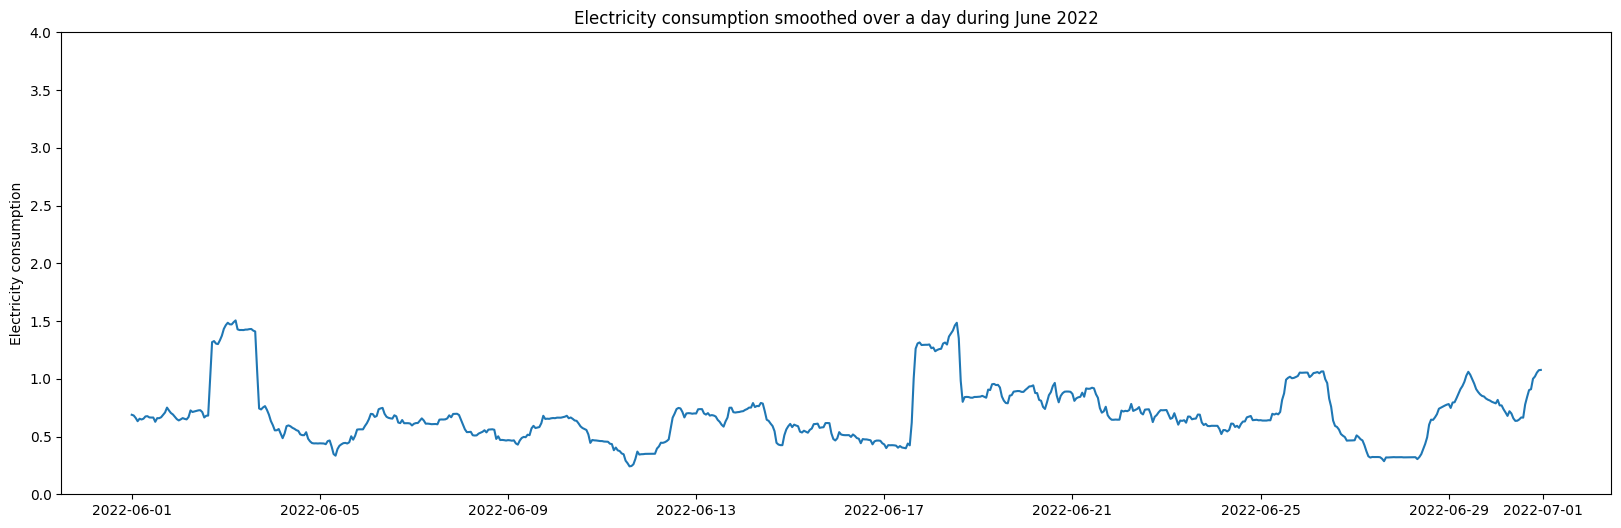

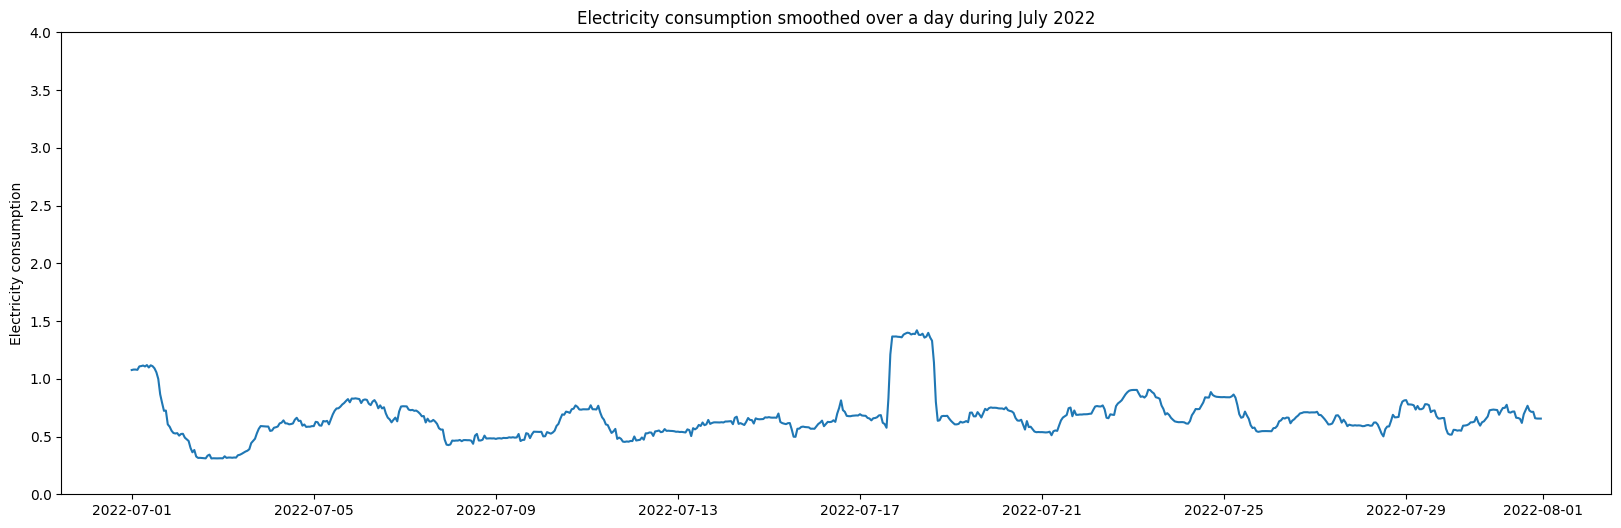

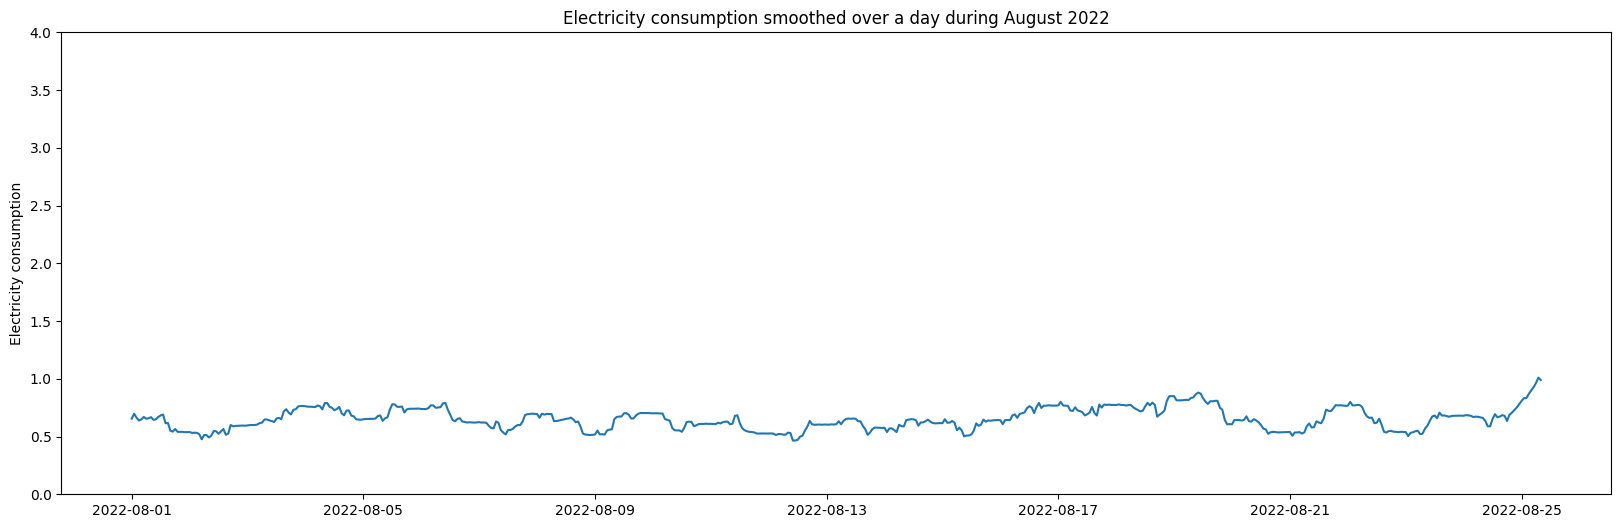

In [76]:
df_roll = df['consumption'].rolling(timedelta(days=1), min_periods=12).mean()
for month in pd.date_range(start='2021-09-01', end='2022-08-31', freq='M'):
    plt.figure(figsize=(20, 6))
    plt.ylabel("Electricity consumption")
    plt.ylim(0, 4)
    plt.title("Electricity consumption smoothed over a day during " + month.strftime("%B %Y"))
    plt.plot(df_roll[month.strftime("%Y-%m")])
    plt.show()

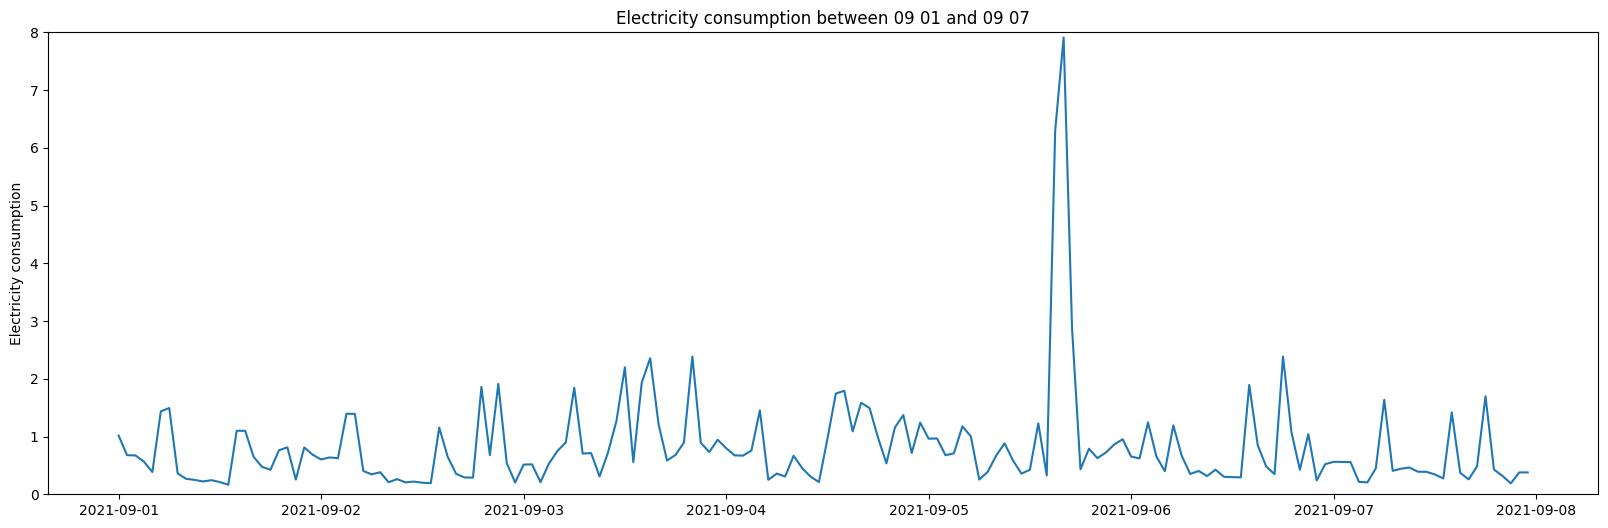

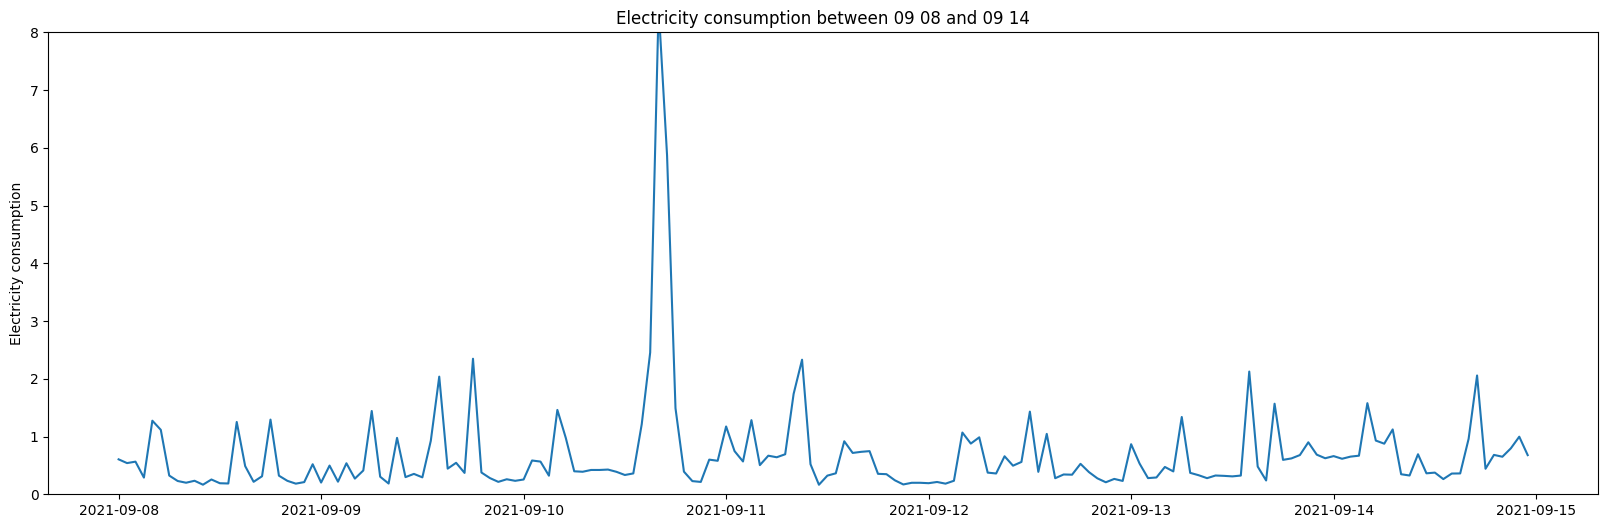

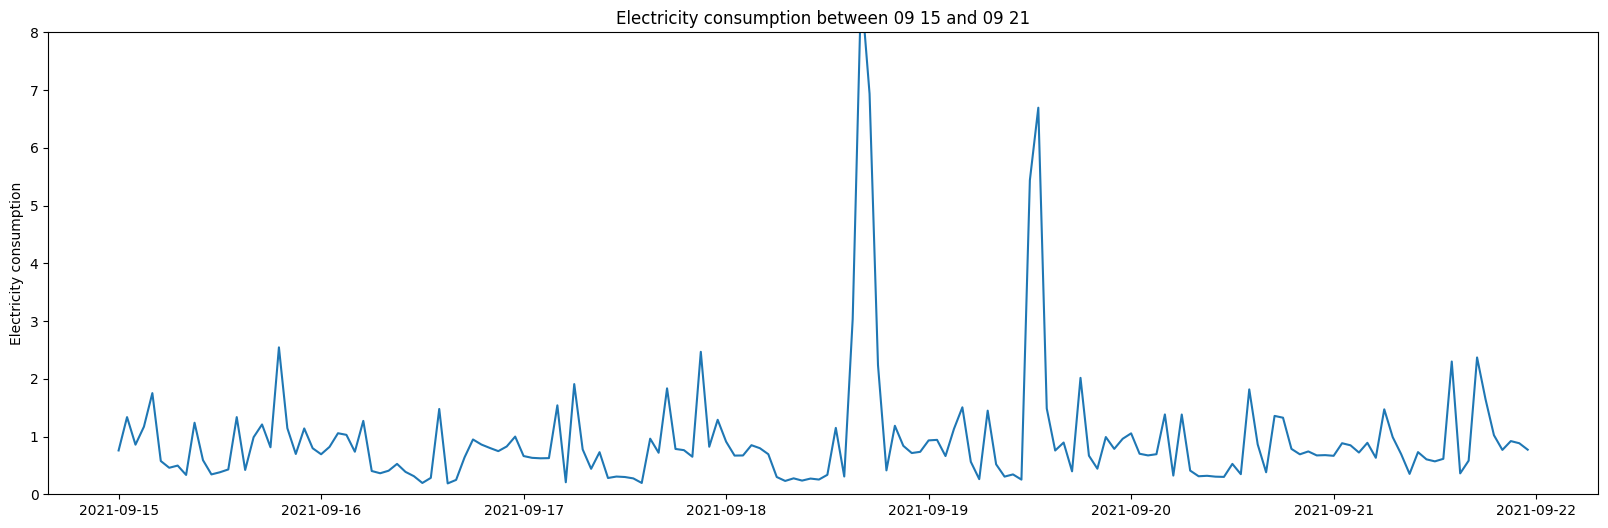

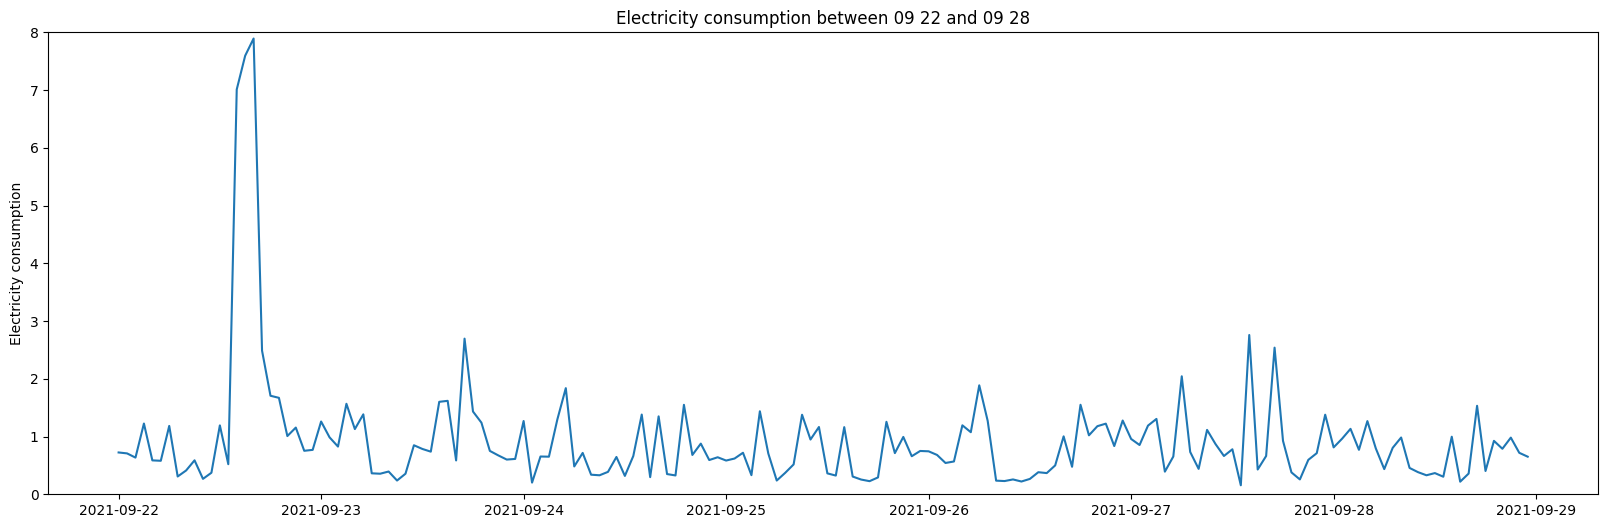

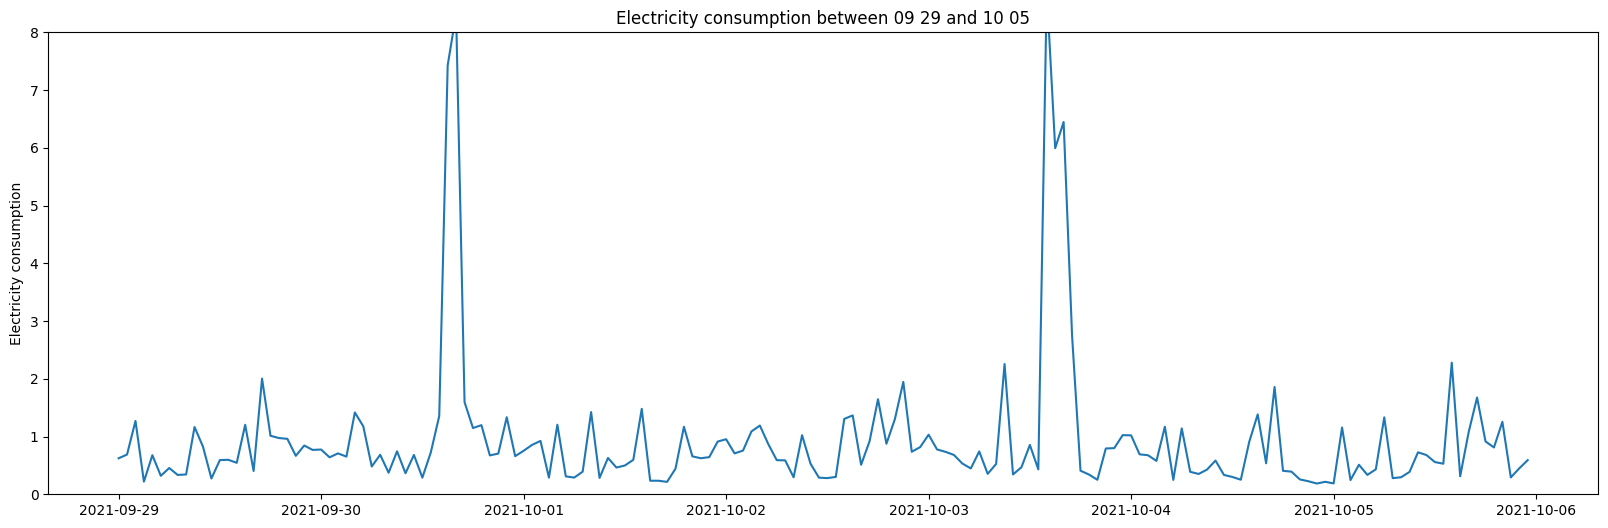

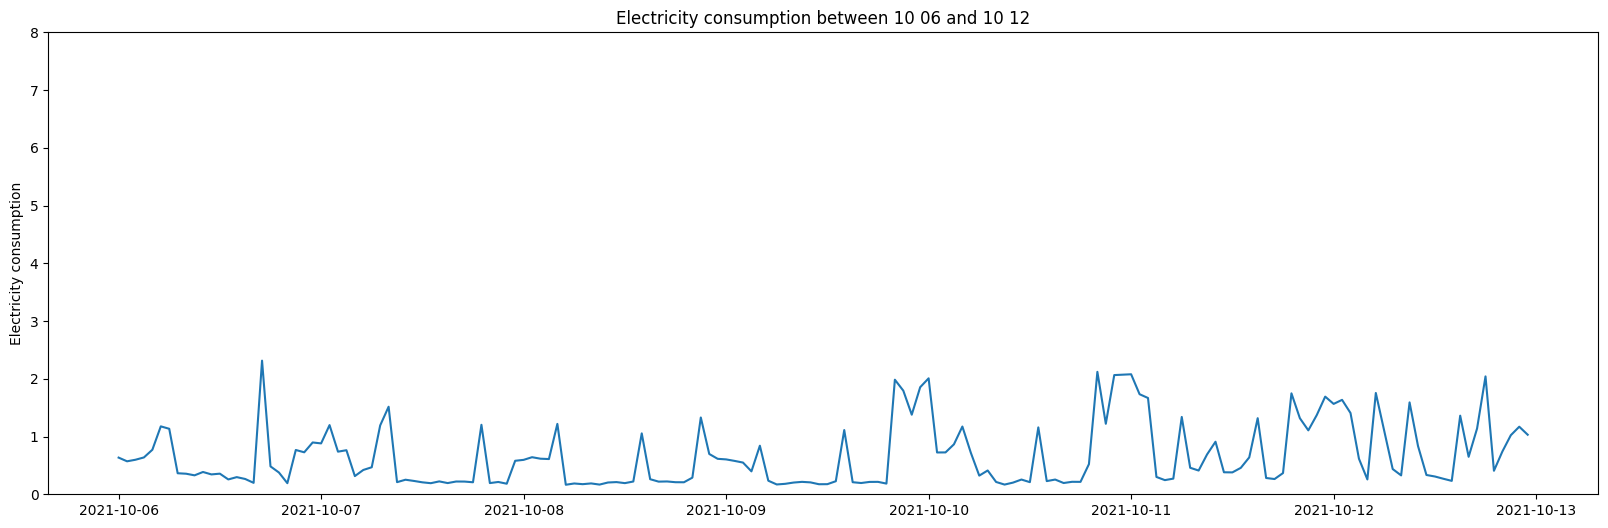

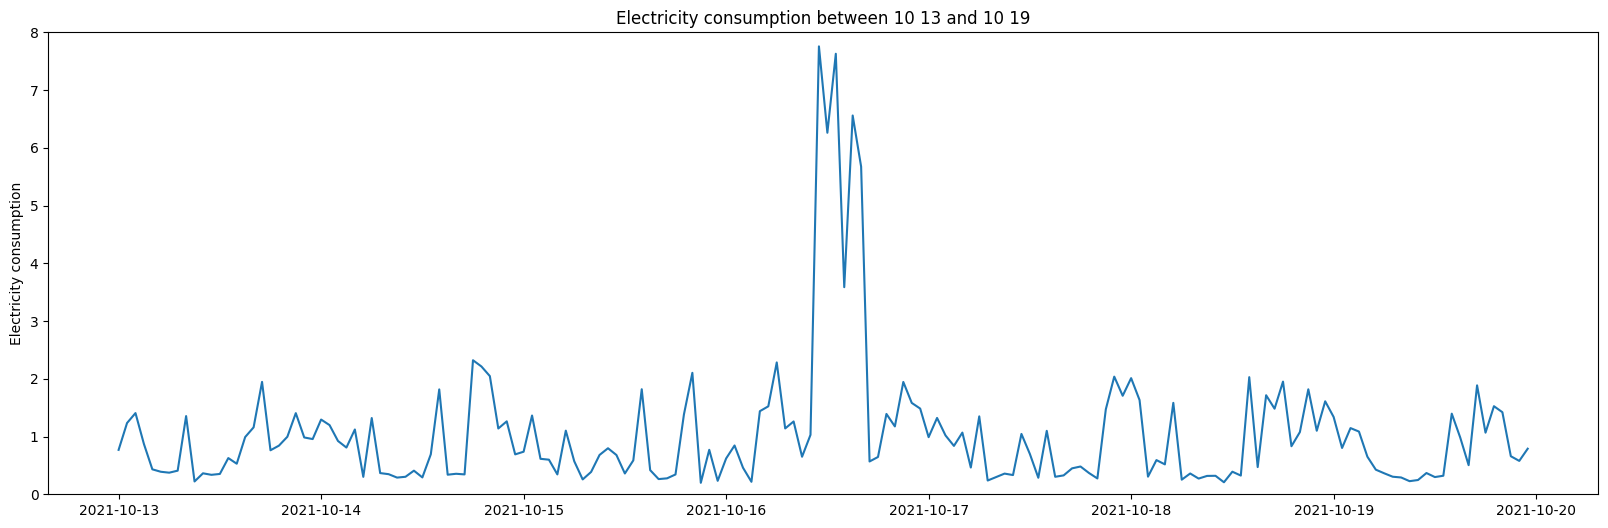

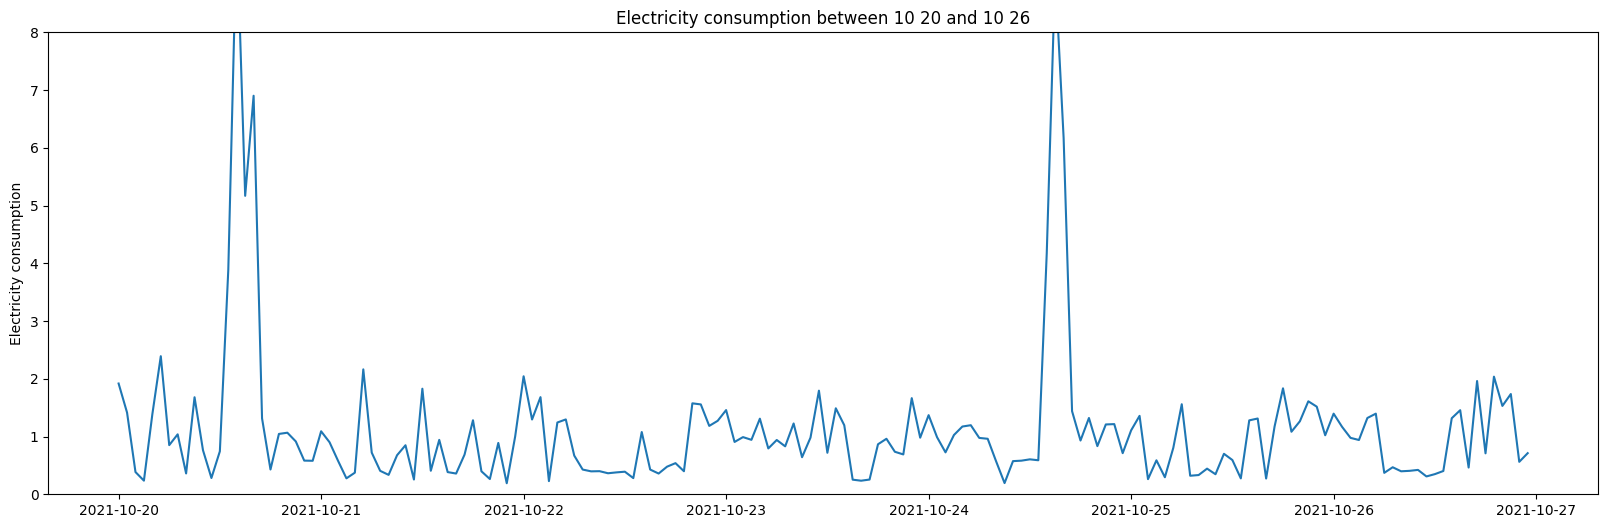

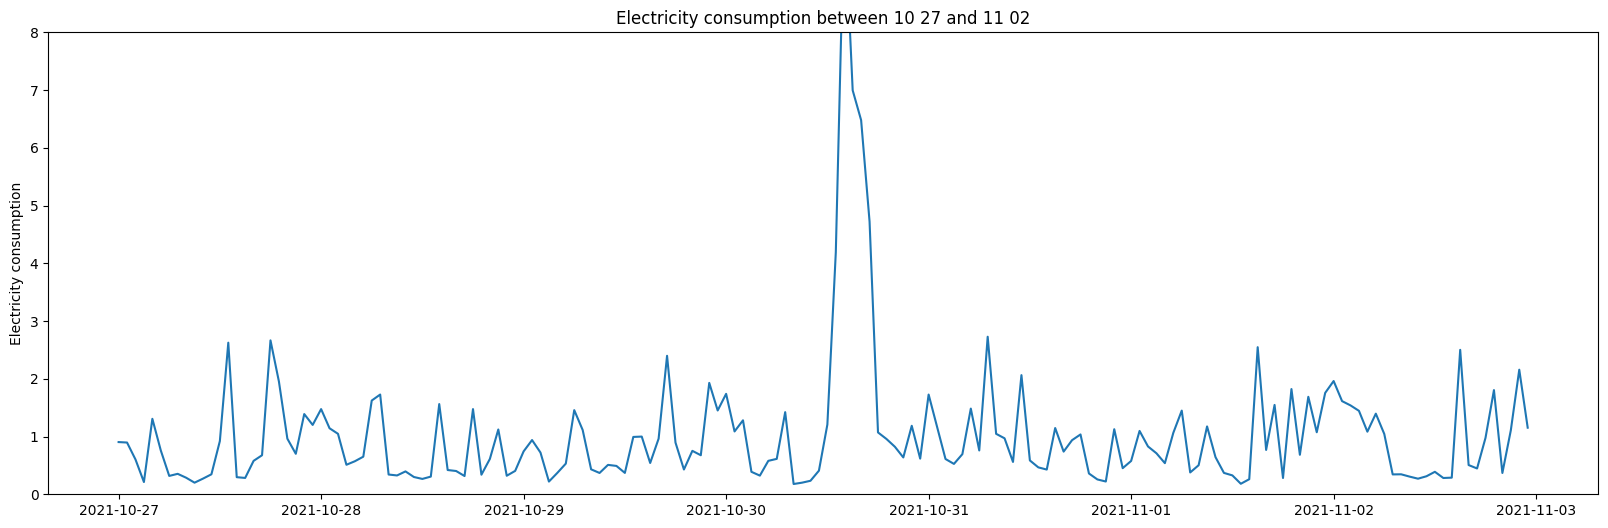

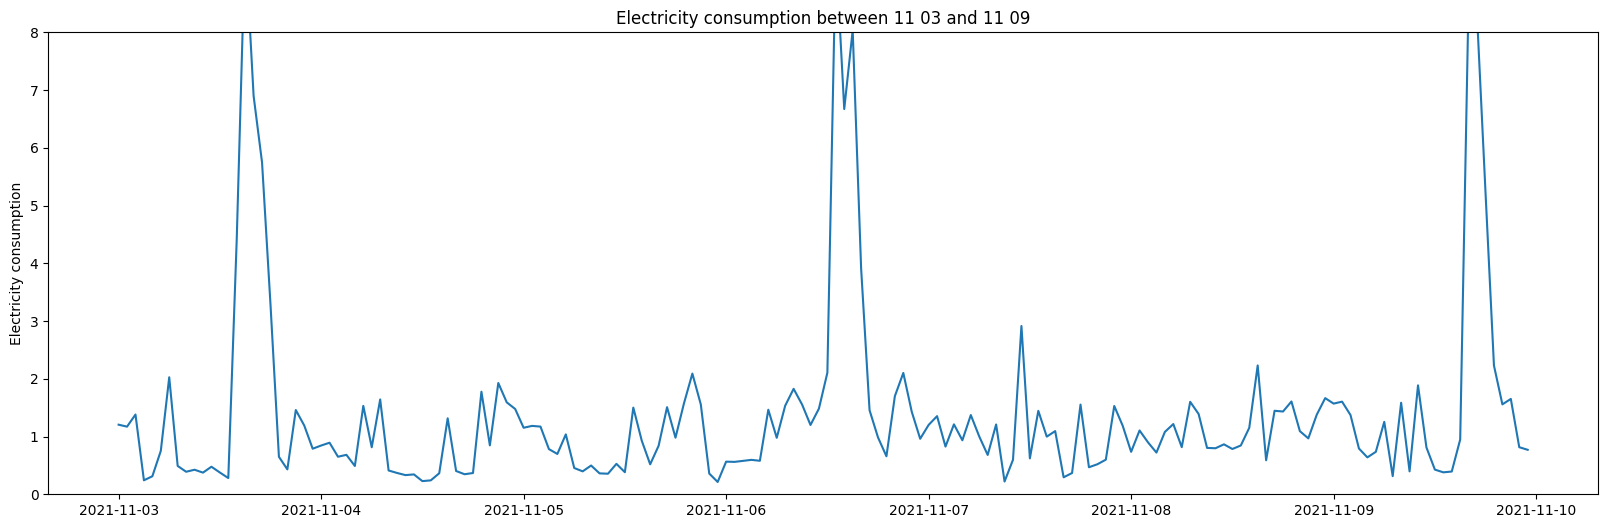

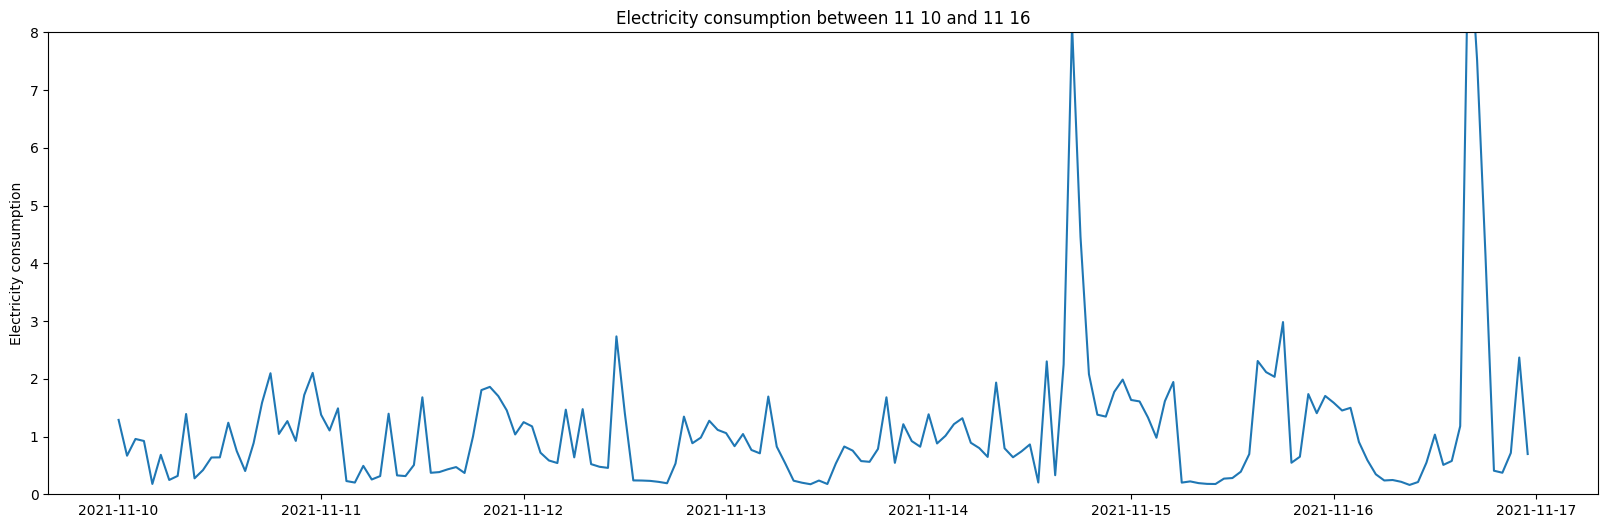

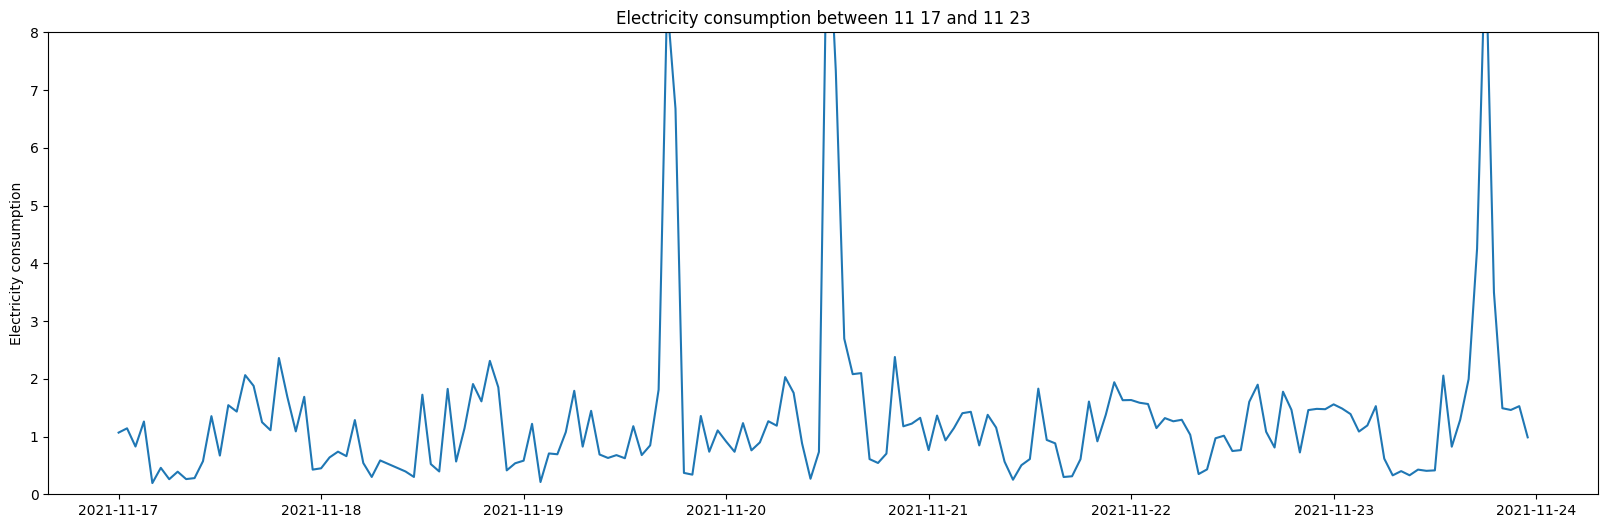

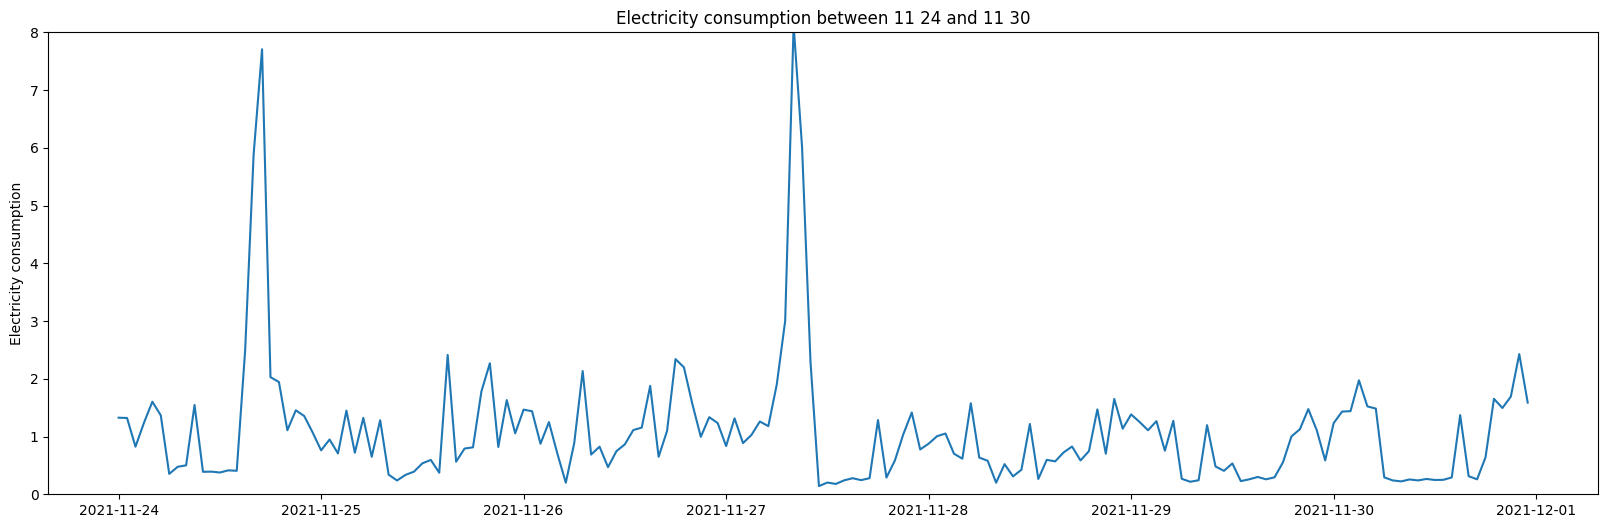

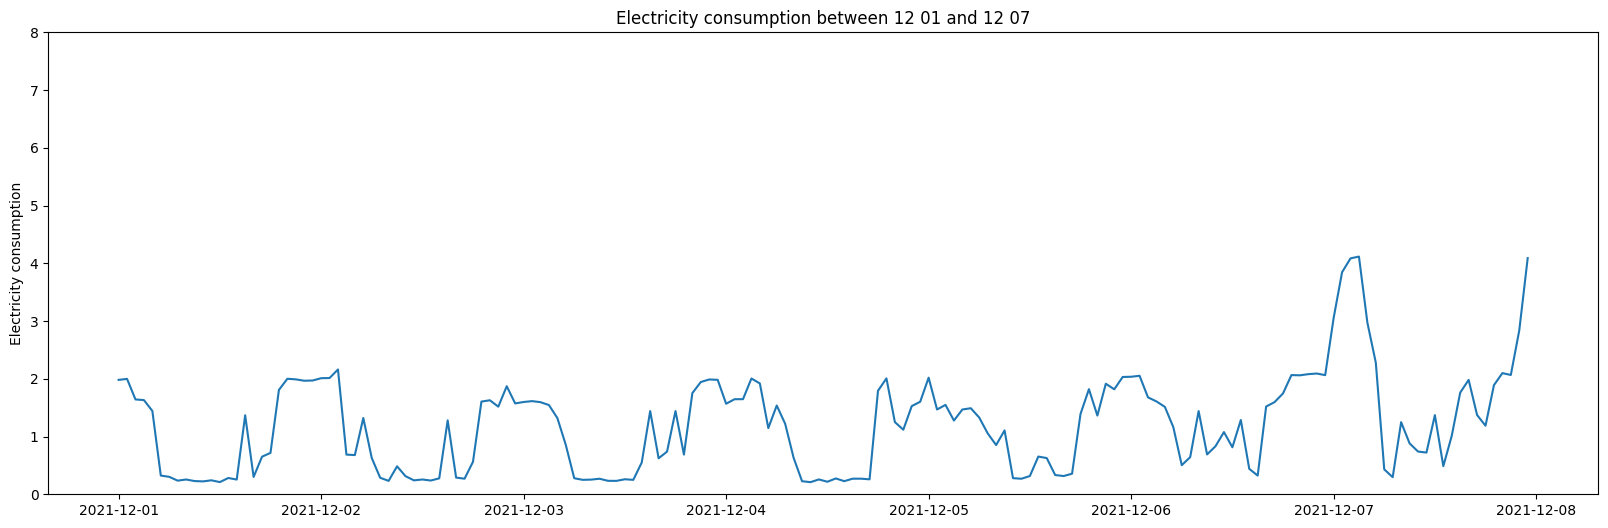

In [77]:
for day_start in pd.date_range(start='2021-09-01', periods=14, freq='7D'):
    day_end = day_start + timedelta(days=6)
    plt.figure(figsize=(20, 6))
    plt.ylabel("Electricity consumption")
    plt.ylim(0, 8)
    plt.title("Electricity consumption between " + day_start.strftime("%m %d") + " and " + day_end.strftime("%m %d"))
    plt.plot(df.loc[day_start.strftime("%Y-%m-%d"):day_end.strftime("%Y-%m-%d"), 'consumption'])
    plt.show()

We can see some peaks, with no obvious frequency. Maybe an oven or a washing machine.

### Datetime aggregates

#### Individual

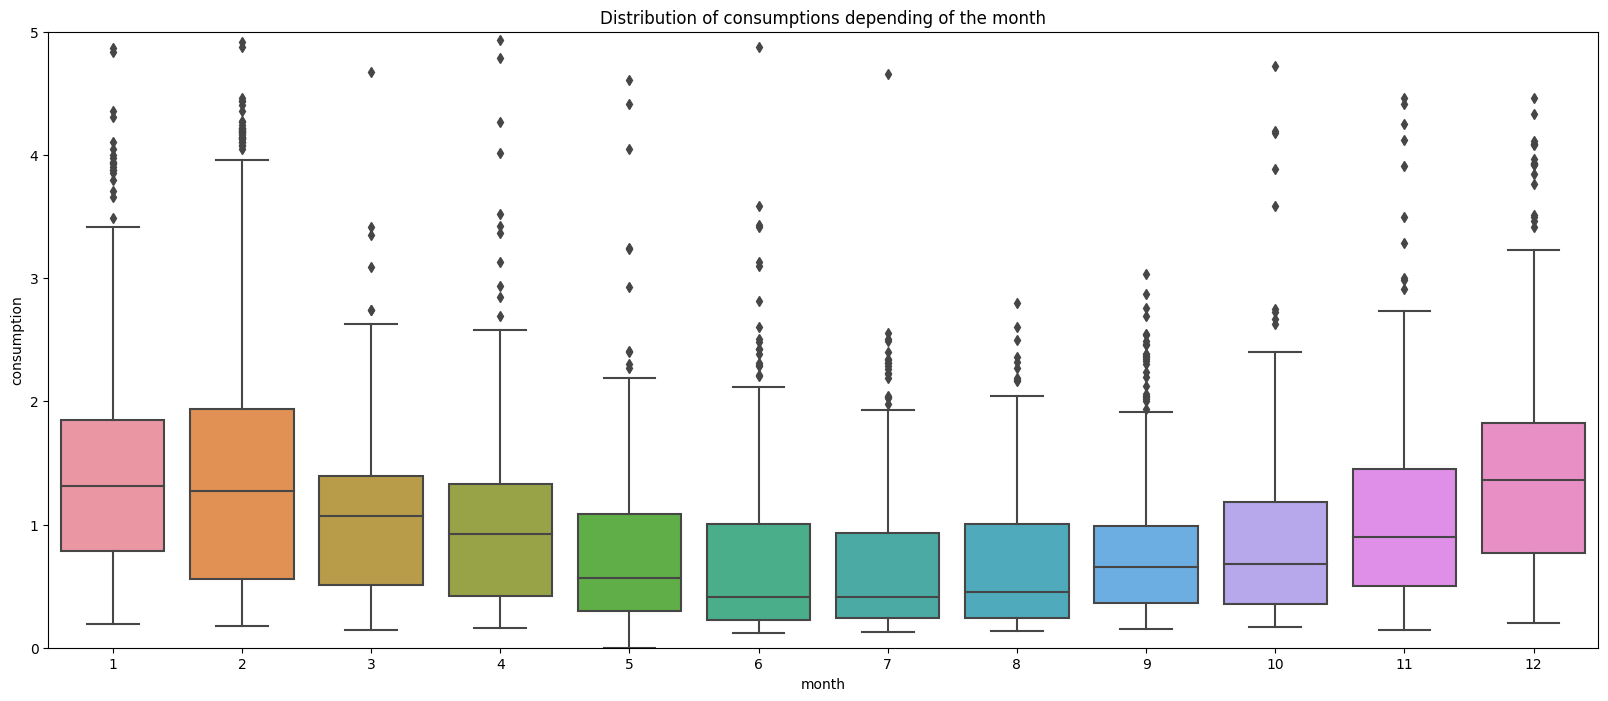

In [78]:
plt.figure(figsize=(20, 8))
sns.boxplot(x="month", y="consumption", data=df)
plt.ylim(0, 5)
plt.title("Distribution of consumptions depending of the month")
plt.show()

Seasonal trend: high consumptions in winter, low consumptions in sommer

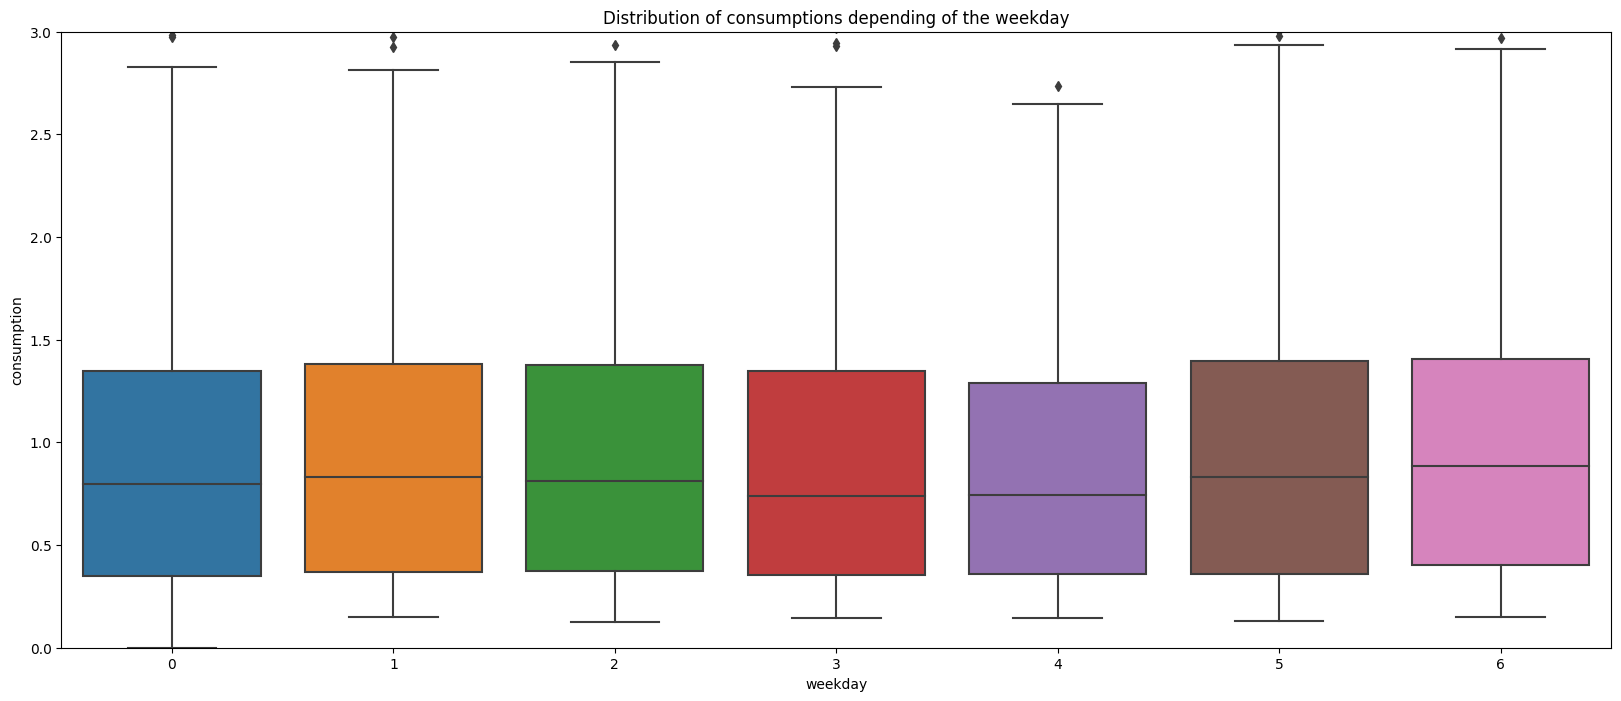

In [79]:
plt.figure(figsize=(20, 8))
sns.boxplot(x="weekday", y="consumption", data=df)
plt.ylim(0, 3)
plt.title("Distribution of consumptions depending of the weekday")
plt.show()

Weekday has less impact on consumption. On Saturday and Sunday, consumption is a bit higher though.

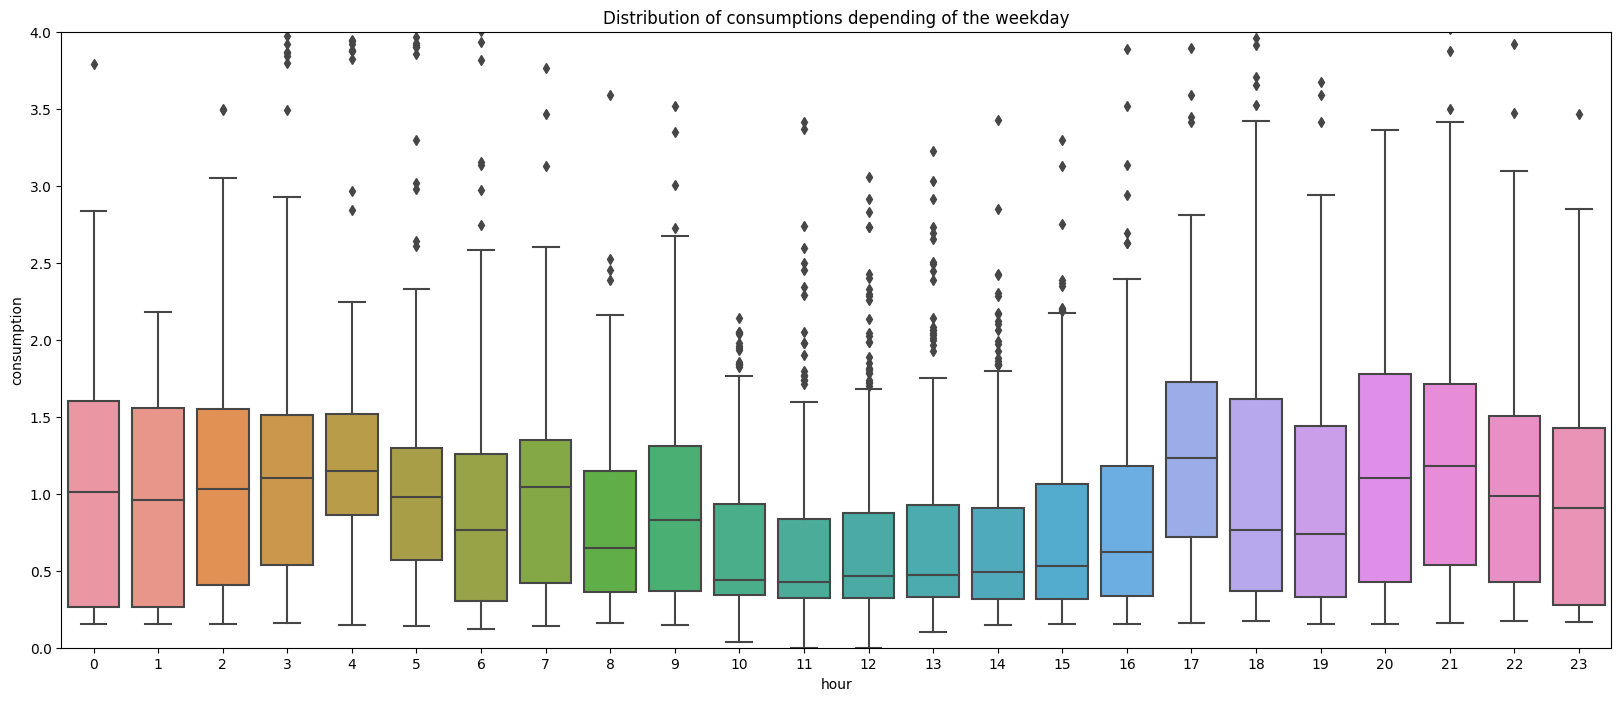

In [80]:
plt.figure(figsize=(20, 8))
sns.boxplot(x="hour", y="consumption", data=df)
plt.ylim(0, 4)
plt.title("Distribution of consumptions depending of the weekday")
plt.show()

We see some group of hours which have similar distribution. Night hours have a wide distribution, mi-day hours are always low, evening hours are higher. At 4 am the consumption is always high also.

#### Cross effect

C:\Users\pavel\AppData\Local\Temp\ipykernel_24248\3042493924.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = df.groupby(["month", "weekday"]).mean()['consumption'].reset_index()


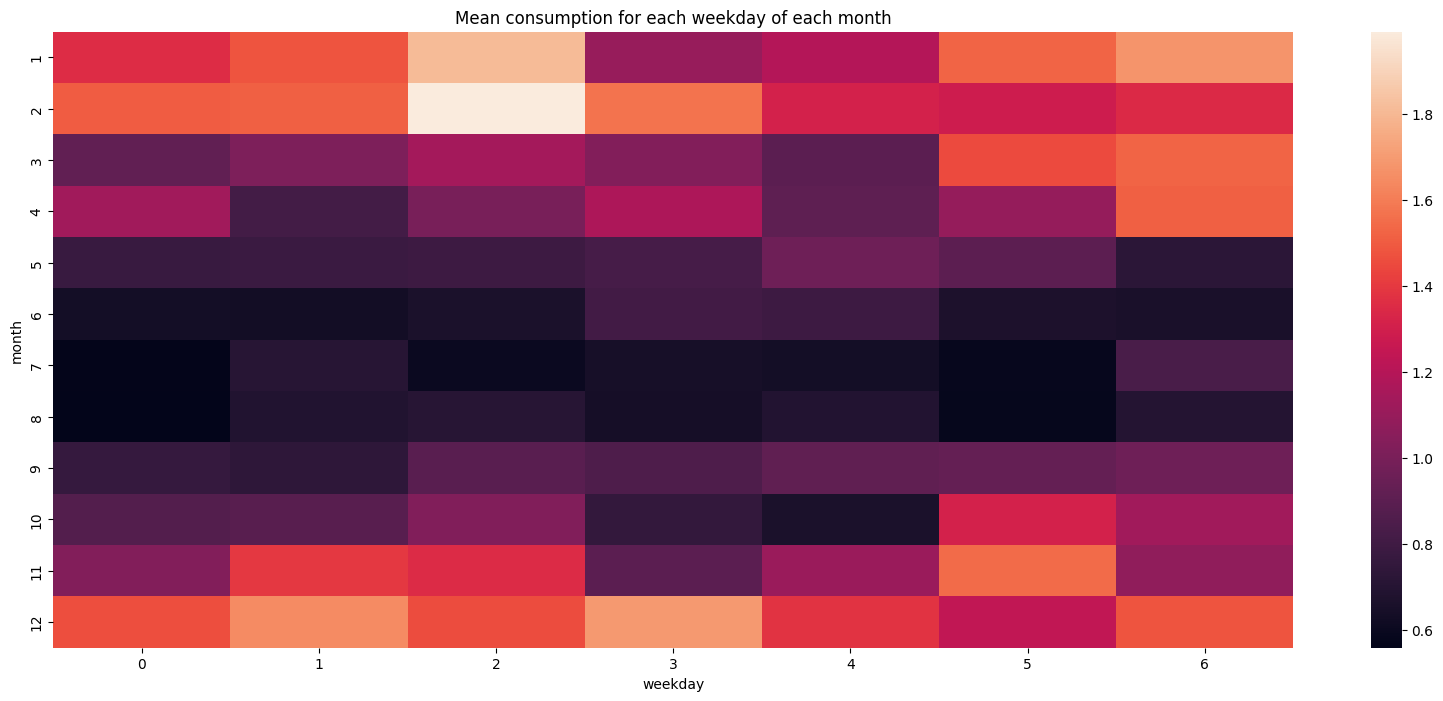

In [81]:
df_grouped = df.groupby(["month", "weekday"]).mean()['consumption'].reset_index()
df_grouped = df_grouped.pivot(index='month', columns='weekday', values='consumption')
plt.figure(figsize=(20, 8))
sns.heatmap(df_grouped)
plt.title("Mean consumption for each weekday of each month")
plt.show()

Cross effect of weekday and month shows that weekends are usually high in consumption during winter more than during sommer. Wednesdays of January and February look very unusual.

C:\Users\pavel\AppData\Local\Temp\ipykernel_24248\3903114995.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = df.groupby(["month", "hour"]).mean()['consumption'].reset_index()


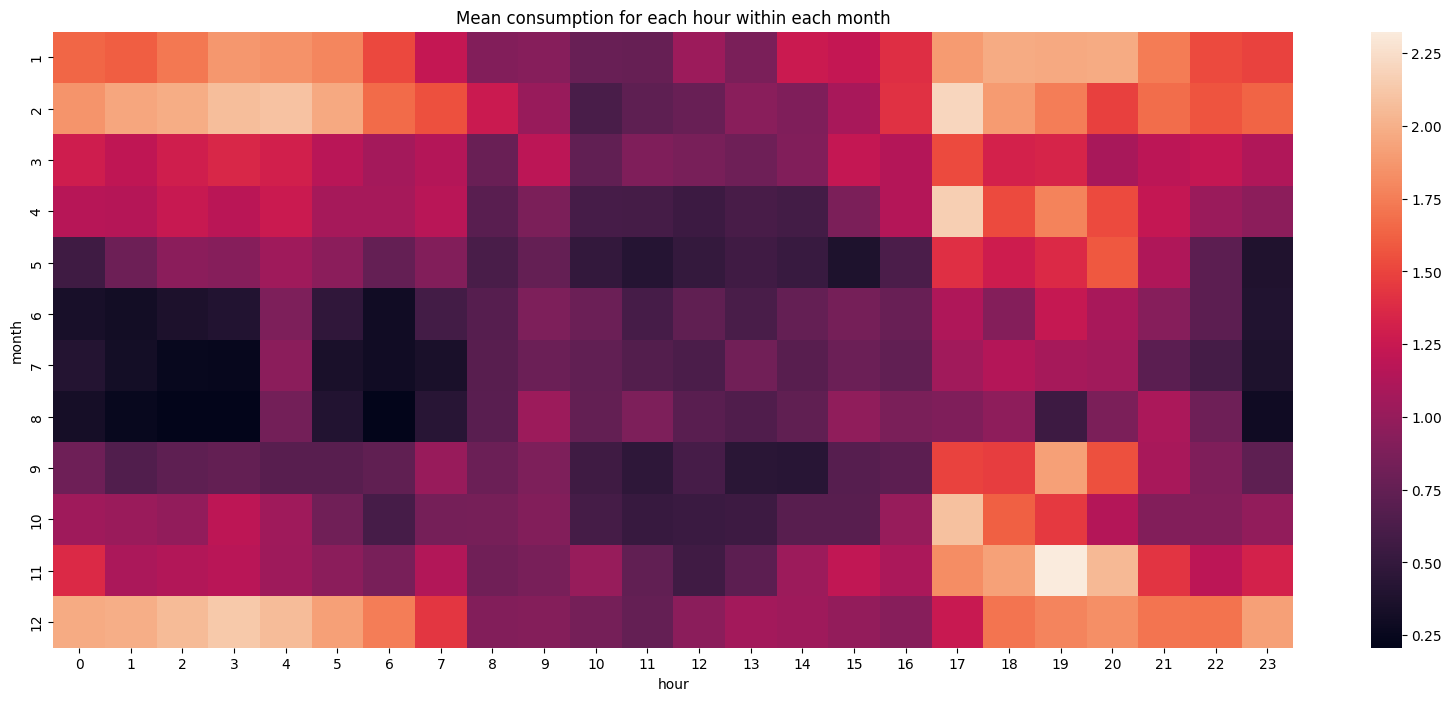

In [82]:
df_grouped = df.groupby(["month", "hour"]).mean()['consumption'].reset_index()
df_grouped = df_grouped.pivot(index='month', columns='hour', values='consumption')
plt.figure(figsize=(20, 8))
sns.heatmap(df_grouped)
plt.title("Mean consumption for each hour within each month")
plt.show()

Cross effect of hour and month shows that 17 is always a break in the day for more consumption. Whereas 8 is a break for less consumption in winter and more consumption sommer.

C:\Users\pavel\AppData\Local\Temp\ipykernel_24248\2149286003.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = df.groupby(["weekday", "hour"]).mean()['consumption'].reset_index()


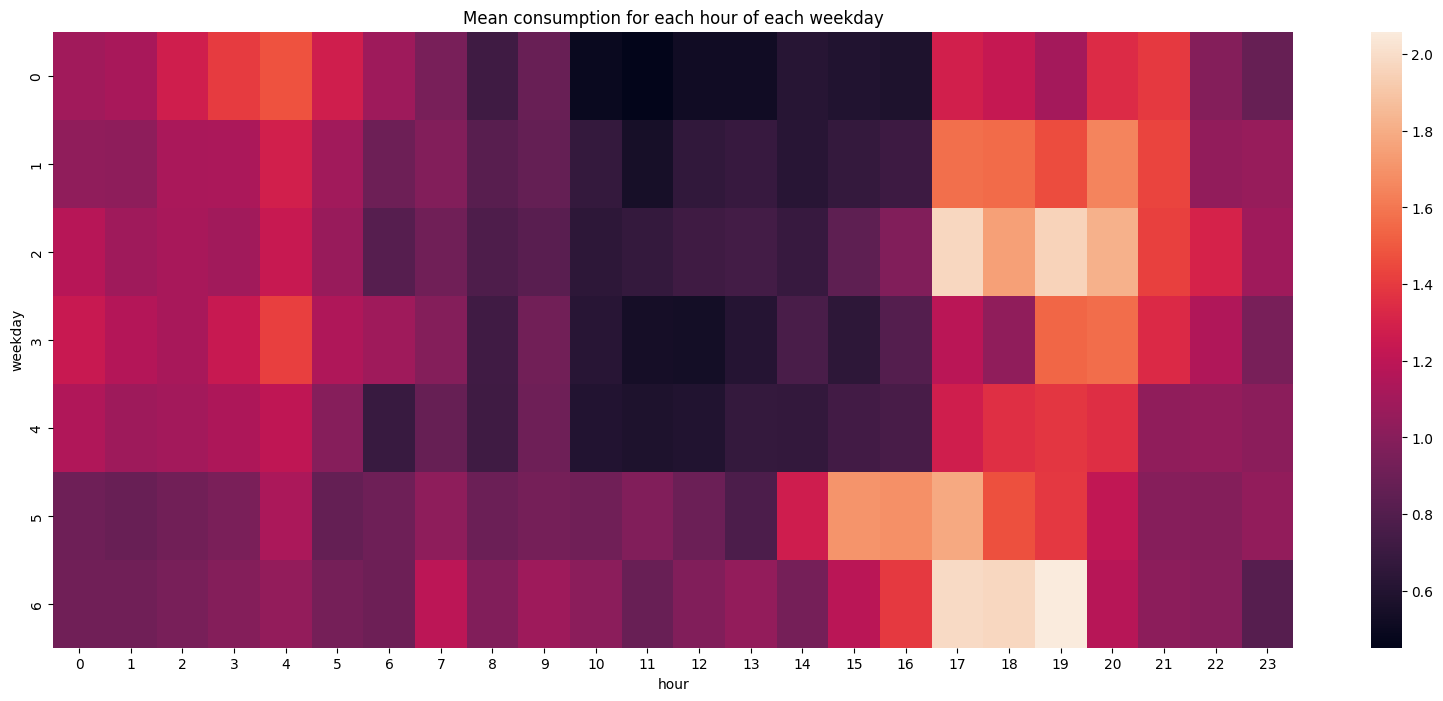

In [83]:
df_grouped = df.groupby(["weekday", "hour"]).mean()['consumption'].reset_index()
df_grouped = df_grouped.pivot(index='weekday', columns='hour', values='consumption')
plt.figure(figsize=(20, 8))
sns.heatmap(df_grouped)
plt.title("Mean consumption for each hour of each weekday")
plt.show()

Cross effect of hour and weekday clearly shows the different hours of consumption depending of the weekday. Saturday and Sunday have each a unique profile with their peak hours. Wednesday looks also a bit different from other weekdays.

## Electricity price

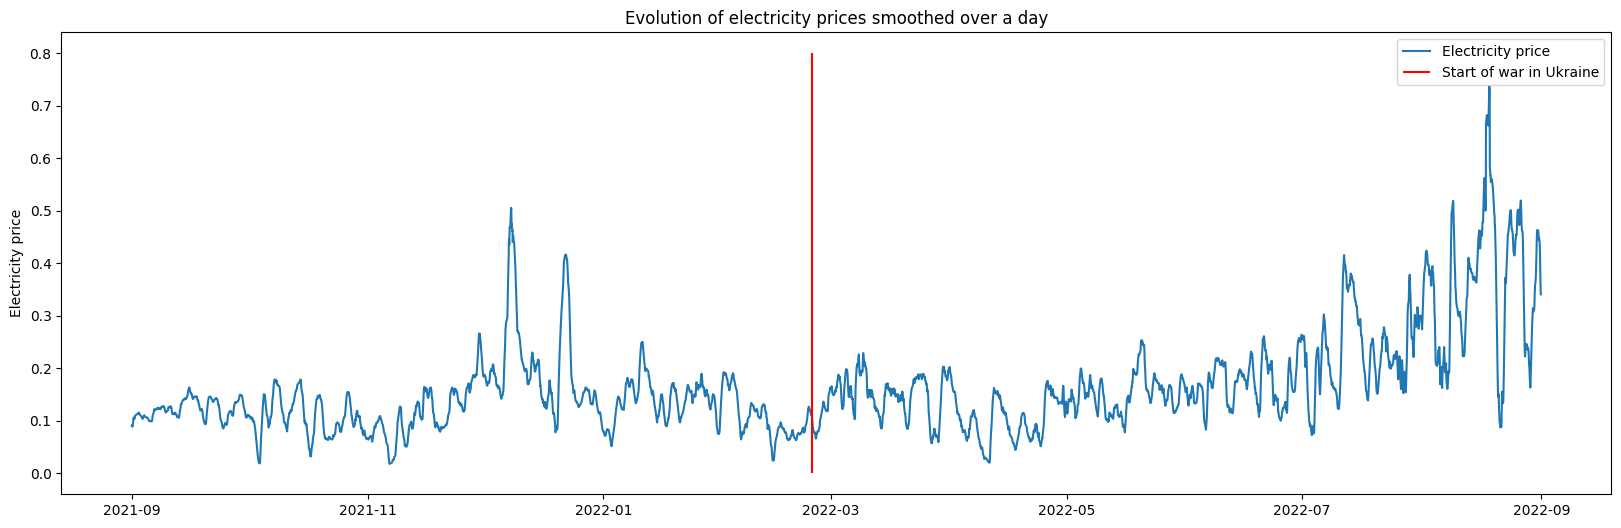

In [84]:
plt.figure(figsize=(20, 6))
plt.plot(df['el_price'].rolling(timedelta(days=1), center=False).mean(), label="Electricity price")
plt.ylabel("Electricity price")
plt.title("Evolution of electricity prices smoothed over a day")
plt.vlines(x=pd.Timestamp("2022-02-24"), ymin=0, ymax=0.8, colors='red', label="Start of war in Ukraine")
plt.legend()
plt.show()

We see high prices in winter but not only. I showed the date of the Start of the war in Ukraine because it has impacted electricity supply in Europe. Prices increased despite electricity consumption decrease.

That's why it might be interesting to look at a relative price (i.e. compared to previous day) instead of this raw price.

## Rain

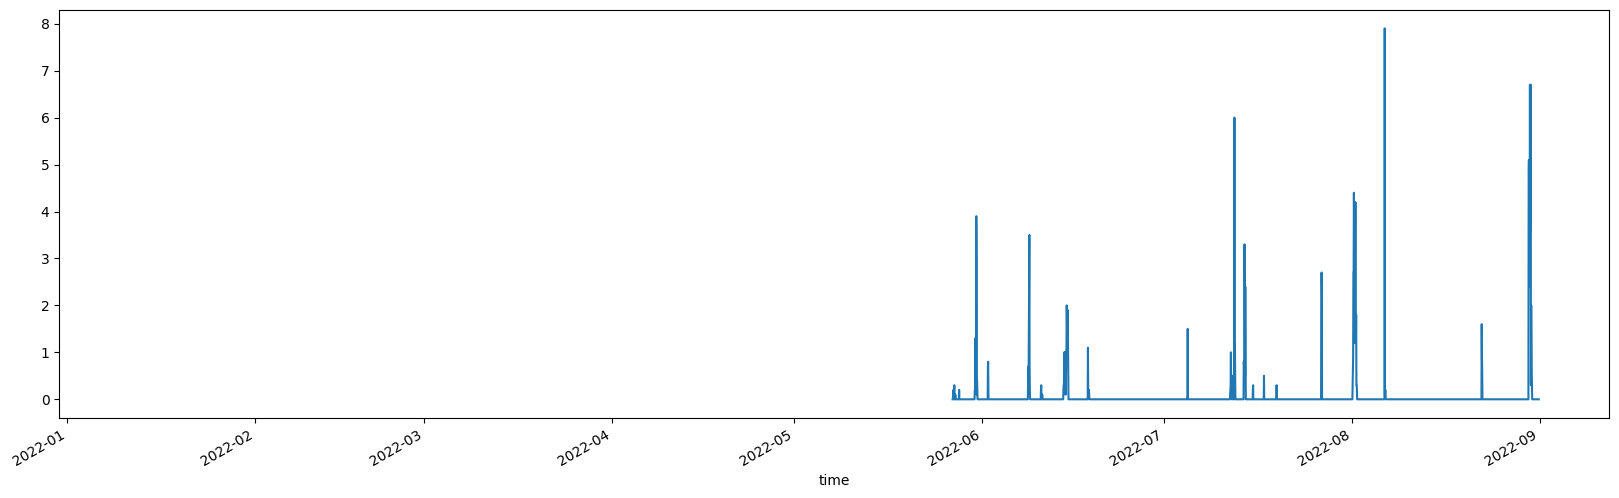

In [85]:
# Prcp
plt.figure(figsize=(20, 6))
df['prcp'].plot()
plt.show()

For 'prcp' we have missing values, the column has values only after June so we have several possibilities:
- fill it:
    1. from on an external source
    2. based on inferance from other columns (especially condition code "coco")
- remove it
- keep it as such and train a model only with data starting after June

# Feature engineering

In [86]:
# Get a relative (compared to the day before) elec price
def add_relative_price(data):
    data['relative_price'] = (data['el_price'] - data['el_price'].rolling(timedelta(days=1), center=False).mean()) * 1000
    return data
df = add_relative_price(df)

In [87]:
# I took holidays from official Estonian website
# For sure, electricity consumption is different if you work or not
pulic_holidays = [
    datetime(2021, 12, 24),
    datetime(2021, 12, 25),
    datetime(2021, 12, 26),
    datetime(2022, 1, 1),
    datetime(2022, 2, 24),
    datetime(2022, 4, 15),
    datetime(2022, 4, 17),
    datetime(2022, 5, 1),
    datetime(2022, 6, 23),
    datetime(2022, 6, 24),
    datetime(2022, 8, 20),
]
# School holidays are interesting if there are children in the household
school_holidays = [
    [datetime(2021, 10, 23), datetime(2021, 10, 31)],
    [datetime(2021, 12, 23), datetime(2022, 1, 9)],
    [datetime(2022, 2, 26), datetime(2022, 3, 6)],
    [datetime(2022, 4, 23), datetime(2022, 5, 1)],
    [datetime(2022, 6, 14), datetime(2022, 8, 31)],
]

In [88]:
def add_holidays(df):
    data = df.copy()
    data['date'] = data.apply(lambda x: datetime(int(x['time'][:4]), int(x['time'][5:7]), int(x['time'][8:10])), axis=1)
    data['public_holiday'] = data.apply(lambda x: x['date'] in pulic_holidays, axis=1) * 1
    data['school_holiday'] = 0
    for school_holiday_range in school_holidays:
        date_range = pd.date_range(school_holiday_range[0], school_holiday_range[1])
        data.loc[data.apply(lambda x: x['date'] in date_range, axis=1), 'school_holiday'] = 1
    data = data.drop('date', axis=1)
    return data
df = add_holidays(df)

In [89]:
# The aim is that 0 and 360 degrees look similar in the data
def circular_wind(data):
    data['wdir_cos'] = np.cos(data['wdir'] / 360 * 2 * pi)
    data['wdir_sin'] = np.sin(data['wdir'] / 360 * 2 * pi)
    data = data.drop(['wdir'], axis=1)
    return data
df = circular_wind(df)

In [90]:
# The length of the test dataset is 1 week, so it is the latest datetime I can get for all rows in the test dataset.
# Moreover, we saw that we have patterns accross days so it is relevant this way as well.
def add_shift_conso(data):
    data['consumption_1w_ago'] = data['consumption'].shift(freq=timedelta(days=7))
    data = data.dropna(subset='consumption_1w_ago')
    return data
df = add_shift_conso(df)

In [91]:
# Transform month into a circular feature might be interesting, not for weekday and hour
# because their behaviour looks far more categorical than seasonal
# But we can also transform number of days since begining of new year. The idea is the same.
def circular_datetime(df):
    data = df.copy()
    # 0 is January
    data['month_cos'] = np.cos((data['month'] - 1) / 12 * 2 * pi)
    data['month_sin'] = np.sin((data['month'] - 1) / 12 * 2 * pi)
    data['hour_cos'] = np.cos(data['hour'] / 24 * 2 * pi)
    data['hour_sin'] = np.sin(data['hour'] / 24 * 2 * pi)
    data['weekday_cos'] = np.cos(data['weekday'] / 7 * 2 * pi)
    data['weekday_sin'] = np.sin(data['weekday'] / 7 * 2 * pi)
    #data['month_cos'] = np.cos((data['time'].apply(lambda x: datetime.fromisoformat(x).toordinal()) - 738170) / 365 * 2 * pi)
    #data['month_sin'] = np.sin((data['time'].apply(lambda x: datetime.fromisoformat(x).toordinal()) - 738170) / 365 * 2 * pi)
    return data
df = circular_datetime(df)

In [92]:
# For prcp data, the easiest way is to remove it as there are too many missing data
# I still keep it in another dataset in case we want to train only on June and July
def drop_prcp(data):
    data = data.drop('prcp', axis=1)
    return data
df_rain = df.dropna(subset='prcp')
df = drop_prcp(df)

C:\Users\pavel\AppData\Local\Temp\ipykernel_24248\2216895006.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


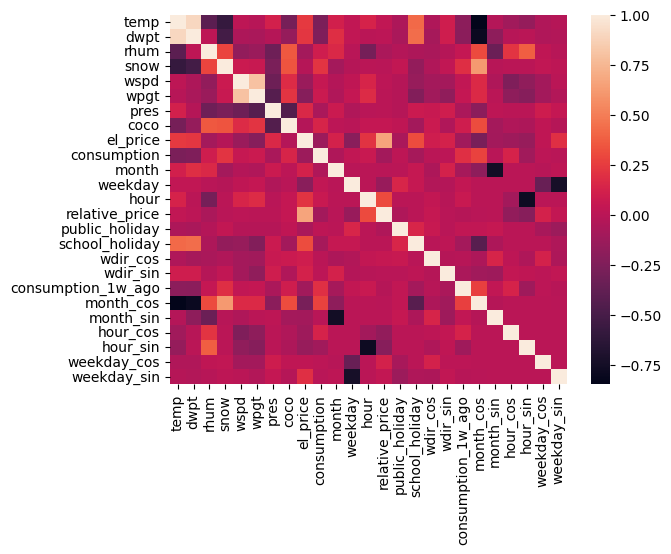

In [93]:
# look for correlation between features
corr = df.corr()
sns.heatmap(corr)
plt.show()

Variables are all pretty linearly uncorrelated. Best correlation is between Temperature and Dew Point with 90%.
So let's keep them all

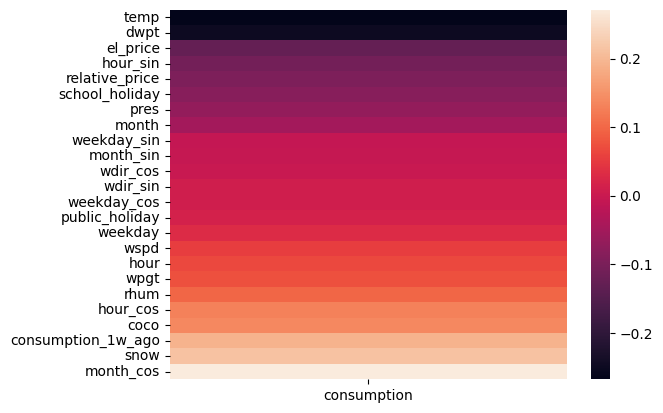

In [94]:
sns.heatmap(corr[['consumption']].drop('consumption').sort_values('consumption'))
plt.show()

Most correlated values with Consumption are +/- 0.2

Negatively correlated are Temperature and Dew Point.

Positively correlated are the cosinus of the month and Depth of snow

# Machine Learning

We are facing a timeseries forecasting problem. So we have to take care of training strategy and how we evaluate and compare our models.

The test dataset is immediately consecutive to the end of the training set. So I will reproduce this situation when training and evaluating my models.

Another crucial point is wether we want to use all data to train our model. You will see in the below code that I prefer to use the amount of training data as a parameter. I will also try to train on as much data as possible and look wether score increases.

Also I wanted to evaluate my models always on the same 10-folds that hold each 1 week of data (like in testset), independantly of the size of the training data used.

The metric I'm looking at are Mean MAE and also k9 MAE because I assume the model will behave similarly on test data

In [95]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor

In [96]:
# this function implements a sliding window walk forward validation scheme with 10 folds then tests 
# the provided list of models. It returns a dataframe with the Mean Average Errors
# train_quotient is the quotient of training data that is used for training a model

def evaluate_models_sliding_window(X, y, models, model_names, train_quotient=5):
    results_list = []   
    for name, model in zip(model_names, models):
        print("running sliding window", name)
        n_test = test_raw.shape[0]
        n_train = (X.shape[0] - n_test) // train_quotient
        print("n_train", n_train)
        model_list = [name]
        mae_list = []
        for i in range(10):
            lim = ((X.shape[0] - n_test) * (9 + i)) // 18
            X_train, X_test = X[lim - n_train:lim], X[lim:lim+n_test]
            y_train, y_test = y[lim - n_train:lim], y[lim:lim+n_test]
            #print("train min max", X_train.index[0], X_train.index[-1])
            #print("test min max", X_test.index[0], X_test.index[-1])
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred)
            mae_list.append(mae)
        model_list.extend(mae_list)    
        model_list.append(np.mean(mae_list))
        results_list.append(model_list)
    df = pd.DataFrame(results_list, columns=["model", "k0_mae", "k1_mae", "k2_mae", "k3_mae", "k4_mae", "k5_mae", "k6_mae", "k7_mae", "k8_mae", "k9_mae", "mae_mean"])  
    return df

In [97]:
# Same but with an expanding window

def evaluate_models_expanding_window(X, y, models, model_names):
    results_list = []   
    for name, model in zip(model_names, models):
        print("running expanding window", name)
        n_test = test_raw.shape[0]
        n_train = (X.shape[0] - n_test) // 5
        model_list = [name]
        mae_list = []
        for i in range(10):
            lim = ((X.shape[0] - n_test) * (9 + i)) // 18
            X_train, X_test = X[:lim], X[lim:lim+n_test]
            y_train, y_test = y[:lim], y[lim:lim+n_test]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred)
            mae_list.append(mae)
        model_list.extend(mae_list)    
        model_list.append(np.mean(mae_list))
        results_list.append(model_list)
    df = pd.DataFrame(results_list, columns=["model", "k0_mae", "k1_mae", "k2_mae", "k3_mae", "k4_mae", "k5_mae", "k6_mae", "k7_mae", "k8_mae", "k9_mae", "mae_mean"])
    return df

In [98]:
# one-hot encode categorical columns and standard scale numerical columns
cat_columns = ['coco', 'weekday', 'hour', 'month']
num_columns = ['temp', 'dwpt', 'rhum', 'snow', 'wspd', 'wpgt', 'pres', 'el_price', 'relative_price', 'wdir_cos',
               'wdir_sin', 'month_cos', 'month_sin', 'hour_cos', 'hour_sin', 'weekday_sin', 'weekday_cos',
               'consumption_1w_ago', 'public_holiday', 'school_holiday']

col_preprocessing = ColumnTransformer([
    ('numeric_col_preprocessing', StandardScaler(), num_columns),
    ('cat_col_preprocessing', OneHotEncoder(sparse=False, categories='auto'), cat_columns)], 
    remainder='drop')
data_prep_pipeline = Pipeline([('col_preprocessing', col_preprocessing)])

## Sliding window

In [99]:
# models tried

#lin = LinearRegression()
ridge = Ridge()
lasso = Lasso()
EN = ElasticNet()
#DT = DecisionTreeRegressor()
#RF = RandomForestRegressor(n_estimators=100)
EX = ExtraTreesRegressor(n_estimators=200)
#GB = GradientBoostingRegressor()
#KN = KNeighborsRegressor()
XGB = XGBRegressor(n_estimators=5)
SVM = SVR()

all_model_name_list = ["ridge", "lasso", "EX", "EN", "XGB", "SVM"]
all_model_list = [ridge, lasso, EX, EN, XGB, SVM]

In [100]:
# Models that are ensemble of trees
# Aim is to quickly tune number of trees to see if there is any effect on error
tree_model_name_list = []
tree_model_list = []
for n in [2, 5, 20, 50]:
    #RF = RandomForestRegressor(n_estimators=n)
    EX = ExtraTreesRegressor(n_estimators=n*10)
    #GB = GradientBoostingRegressor(n_estimators=n)
    XGB = XGBRegressor(n_estimators=n)
    tree_model_name_list.append("EX_"+str(n*10))
    tree_model_list.append(EX)
    tree_model_name_list.append("XGB_"+str(n))
    tree_model_list.append(XGB)

In [101]:
df_train, df_test = df.dropna(subset='consumption'), df[df['consumption'].isna()]

In [102]:
results = evaluate_models_sliding_window(
    data_prep_pipeline.fit_transform(df_train), df_train['consumption'],
    all_model_list, all_model_name_list)

c:\Users\pavel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


running sliding window ridge
n_train 1650
running sliding window lasso
n_train 1650
running sliding window EX
n_train 1650
running sliding window EN
n_train 1650
running sliding window XGB
n_train 1650
running sliding window SVM
n_train 1650


In [103]:
results.sort_values('mae_mean')

model    k0_mae    k1_mae    k2_mae    k3_mae    k4_mae    k5_mae  \
5    SVM  0.449221  0.386744  0.455741  0.558212  0.614989  0.421926   
4    XGB  0.460234  0.451397  0.486644  0.593216  0.662460  0.487806   
2     EX  0.579971  0.360176  0.460952  0.682244  0.609353  0.562947   
0  ridge  0.514909  0.505959  0.608052  0.585110  0.662459  0.573347   
1  lasso  0.525459  0.595760  0.618136  0.714772  0.785505  0.633826   
3     EN  0.525459  0.595760  0.618136  0.714772  0.785505  0.633826   

     k6_mae    k7_mae    k8_mae    k9_mae  mae_mean  
5  0.438464  0.403854  0.339089  0.351343  0.441958  
4  0.467314  0.442204  0.350515  0.356751  0.475854  
2  0.515402  0.478689  0.340407  0.363294  0.495343  
0  0.528522  0.375663  0.365843  0.361507  0.508137  
1  0.521681  0.473142  0.420948  0.416873  0.570610  
3  0.521681  0.473142  0.420948  0.416873  0.570610

In [104]:
results = evaluate_models_sliding_window(
    data_prep_pipeline.fit_transform(df_train), df_train['consumption'],
    tree_model_list, tree_model_name_list)

c:\Users\pavel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


running sliding window EX_20
n_train 1650
running sliding window XGB_2
n_train 1650
running sliding window EX_50
n_train 1650
running sliding window XGB_5
n_train 1650
running sliding window EX_200
n_train 1650
running sliding window XGB_20
n_train 1650
running sliding window EX_500
n_train 1650
running sliding window XGB_50
n_train 1650


In [105]:
results.sort_values('mae_mean')

model    k0_mae    k1_mae    k2_mae    k3_mae    k4_mae    k5_mae  \
1   XGB_2  0.482933  0.425329  0.471778  0.615072  0.688366  0.450111   
3   XGB_5  0.460234  0.451397  0.486644  0.593216  0.662460  0.487806   
6  EX_500  0.573585  0.355514  0.460093  0.679183  0.614231  0.564310   
2   EX_50  0.544380  0.367456  0.453095  0.671118  0.627719  0.571970   
4  EX_200  0.587324  0.360906  0.465032  0.694546  0.619397  0.564523   
5  XGB_20  0.513399  0.479904  0.479811  0.674471  0.649485  0.496909   
0   EX_20  0.554316  0.373470  0.458476  0.702469  0.649795  0.582704   
7  XGB_50  0.526419  0.540801  0.499863  0.702837  0.637303  0.505902   

     k6_mae    k7_mae    k8_mae    k9_mae  mae_mean  
1  0.427507  0.426039  0.353512  0.363300  0.470395  
3  0.467314  0.442204  0.350515  0.356751  0.475854  
6  0.504245  0.483463  0.340071  0.359475  0.493417  
2  0.537123  0.469444  0.338985  0.354418  0.493571  
4  0.504338  0.474711  0.341891  0.357236  0.496990  
5  0.494723  0.533717  0.354794  0.361336  0.503855  
0  0.532553  0.497944  0.329228  0.377038  0.505799  
7  0.515489  0.652447  0.373201  0.382602  0.533686

## Expanding window

In [106]:
results = evaluate_models_expanding_window(
    data_prep_pipeline.fit_transform(df_train), df_train['consumption'],
    all_model_list, all_model_name_list)

c:\Users\pavel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


running expanding window ridge
running expanding window lasso
running expanding window EX
running expanding window EN
running expanding window XGB
running expanding window SVM


In [107]:
results.sort_values('mae_mean')

model    k0_mae    k1_mae    k2_mae    k3_mae    k4_mae    k5_mae  \
5    SVM  0.417501  0.391845  0.438718  0.554395  0.601197  0.405608   
4    XGB  0.552937  0.369646  0.521291  0.547650  0.672097  0.540324   
2     EX  0.524228  0.381404  0.562534  0.651469  0.586379  0.515352   
0  ridge  0.518020  0.373641  0.494333  0.575351  0.707609  0.584026   
1  lasso  0.458621  0.511003  0.587202  0.746183  0.853445  0.752810   
3     EN  0.458621  0.511003  0.587202  0.746183  0.853445  0.752810   

     k6_mae    k7_mae    k8_mae    k9_mae  mae_mean  
5  0.456089  0.403463  0.344401  0.369129  0.438235  
4  0.473758  0.424391  0.363880  0.394662  0.486063  
2  0.518431  0.477046  0.338538  0.358598  0.491398  
0  0.623070  0.563675  0.508106  0.597698  0.554553  
1  0.671058  0.677562  0.589656  0.584587  0.643213  
3  0.671058  0.677562  0.589656  0.584587  0.643213

In [108]:
results = evaluate_models_expanding_window(
    data_prep_pipeline.fit_transform(df_train), df_train['consumption'],
    tree_model_list, tree_model_name_list)

c:\Users\pavel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


running expanding window EX_20
running expanding window XGB_2
running expanding window EX_50
running expanding window XGB_5
running expanding window EX_200
running expanding window XGB_20
running expanding window EX_500
running expanding window XGB_50


In [109]:
results.sort_values('mae_mean')

model    k0_mae    k1_mae    k2_mae    k3_mae    k4_mae    k5_mae  \
1   XGB_2  0.509505  0.401553  0.522414  0.582560  0.674459  0.496157   
3   XGB_5  0.552937  0.369646  0.521291  0.547650  0.672097  0.540324   
4  EX_200  0.522761  0.374513  0.570951  0.637975  0.571237  0.522799   
6  EX_500  0.514539  0.377277  0.570676  0.638253  0.577843  0.521065   
2   EX_50  0.523337  0.375513  0.575961  0.635333  0.567260  0.520583   
0   EX_20  0.609207  0.421766  0.540716  0.654930  0.560828  0.522278   
5  XGB_20  0.703922  0.376707  0.598504  0.585290  0.687676  0.548297   
7  XGB_50  0.768319  0.448727  0.656482  0.611258  0.702194  0.559458   

     k6_mae    k7_mae    k8_mae    k9_mae  mae_mean  
1  0.417523  0.401283  0.377824  0.378214  0.476149  
3  0.473758  0.424391  0.363880  0.394662  0.486063  
4  0.501327  0.473728  0.340624  0.351685  0.486760  
6  0.506525  0.482228  0.341816  0.359049  0.488927  
2  0.505773  0.499264  0.355290  0.356230  0.491455  
0  0.485247  0.471750  0.345884  0.363487  0.497609  
5  0.528963  0.473035  0.361936  0.378197  0.524253  
7  0.551281  0.572602  0.371523  0.405370  0.564721

Best model is definitely Support Vector Machine Regression

Also sliding window gives better results compared to expanding window

In [110]:
XGB = XGBRegressor(n_estimators=2)
XGB.fit(data_prep_pipeline.fit_transform(df_train.drop(['time', 'consumption'], axis=1)), df_train['consumption'])
feat_imp = pd.Series(XGB.feature_importances_, index=[i.partition('__')[-1] for i in data_prep_pipeline.get_feature_names_out()]).sort_values()


c:\Users\pavel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Tuning SVM

### Select features

The aim is to select only features that help to get a good score and remove others

In [111]:
# one-hot encode categorical columns and standard scale numerical columns
cat_columns = ['hour', 'month', 'coco', 'weekday']
num_columns = ['temp', 'dwpt', 'rhum', 'snow', 'pres', 'el_price', 'wspd', 'wpgt', 'relative_price', 'wdir_cos', 'wdir_sin', 
               'weekday_sin', 'weekday_cos', 'hour_cos', 'hour_sin', 'month_cos', 'month_sin',
               'consumption_1w_ago', 'public_holiday', 'school_holiday']

col_preprocessing = ColumnTransformer([
    ('numeric_col_preprocessing', StandardScaler(), num_columns),
    ('cat_col_preprocessing', OneHotEncoder(sparse=False, categories='auto'), cat_columns)], 
    remainder='drop')
data_prep_pipeline = Pipeline([('col_preprocessing', col_preprocessing)])

results = evaluate_models_sliding_window(
    data_prep_pipeline.fit_transform(df_train), df_train['consumption'],
    [SVM], ['SVR'])

results

c:\Users\pavel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


running sliding window SVR
n_train 1650


model    k0_mae    k1_mae    k2_mae    k3_mae    k4_mae    k5_mae    k6_mae  \
0   SVR  0.449221  0.386744  0.455741  0.558212  0.614989  0.421926  0.438464   

     k7_mae    k8_mae    k9_mae  mae_mean  
0  0.403854  0.339089  0.351343  0.441958

In [112]:
# one-hot encode categorical columns and standard scale numerical columns
cat_columns = ['hour', 'month']#'coco', 'weekday'
num_columns = ['temp', 'dwpt', 'rhum', 'pres', 'el_price', 'wspd', 'wpgt', 'relative_price',# 'wdir_cos','wdir_sin', 
               'weekday_sin', 'weekday_cos', 'hour_cos', 'hour_sin', 'month_cos', 'month_sin',
               'consumption_1w_ago', 'public_holiday']#, 'school_holiday', 'snow'

col_preprocessing = ColumnTransformer([
    ('numeric_col_preprocessing', StandardScaler(), num_columns),
    ('cat_col_preprocessing', OneHotEncoder(sparse=False, categories='auto'), cat_columns)], 
    remainder='drop')
data_prep_pipeline = Pipeline([('col_preprocessing', col_preprocessing)])

results = evaluate_models_sliding_window(
    data_prep_pipeline.fit_transform(df_train), df_train['consumption'],
    [SVM], ['SVR'])

results

c:\Users\pavel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


running sliding window SVR
n_train 1650


model    k0_mae    k1_mae    k2_mae   k3_mae    k4_mae    k5_mae    k6_mae  \
0   SVR  0.443538  0.367193  0.433047  0.51445  0.611218  0.424734  0.439894   

     k7_mae    k8_mae    k9_mae  mae_mean  
0  0.400725  0.333464  0.357505  0.432577

Increase of 0.01 to mean MAE by removing a few columns

### Hyperparameters

Tuning hyperparameters of SVM: kernel, gamma, epsilon and C

In [113]:
# regression models to try

#SVM0 = SVR(kernel='linear')
#SVM1 = SVR(kernel='precomputed')
#SVM2 = SVR(kernel='sigmoid')
#SVM3 = SVR(kernel='sigmoid', gamma='auto')
#SVM4 = SVR(kernel='poly', degree=4)
#SVM5 = SVR(kernel='poly', degree=4, gamma='auto')
#SVM6 = SVR(kernel='poly', degree=3)
#SVM7 = SVR(kernel='poly', degree=3, gamma='auto')

SVM0 = SVR(kernel='rbf', gamma='auto', epsilon=0.01, C=0.5)
SVM1 = SVR(kernel='rbf', gamma='auto', epsilon=0.02, C=0.8)
SVM2 = SVR(kernel='rbf', gamma='auto', epsilon=0.02, C=0.5)
SVM3 = SVR(kernel='rbf', gamma='auto', epsilon=0.1, C=0.8)
SVM4 = SVR(kernel='rbf', gamma='auto', epsilon=0.1, C=0.5)

svr_model_name_list = list(range(10))
svr_model_list = [SVM0, SVM1, SVM2, SVM3, SVM4]

In [114]:
results = evaluate_models_sliding_window(
    data_prep_pipeline.fit_transform(df_train), df_train['consumption'],
    svr_model_list, svr_model_name_list)

c:\Users\pavel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


running sliding window 0
n_train 1650
running sliding window 1
n_train 1650
running sliding window 2
n_train 1650
running sliding window 3
n_train 1650
running sliding window 4
n_train 1650


In [115]:
results.sort_values('mae_mean')

model    k0_mae    k1_mae    k2_mae    k3_mae    k4_mae    k5_mae  \
1      1  0.400742  0.374489  0.443573  0.514307  0.609533  0.403761   
2      2  0.398476  0.375580  0.448326  0.515152  0.620189  0.409782   
0      0  0.396649  0.376377  0.449896  0.514850  0.621717  0.410372   
4      4  0.399386  0.370715  0.441516  0.512350  0.619144  0.417375   
3      3  0.400626  0.372679  0.443043  0.513542  0.610187  0.413552   

     k6_mae    k7_mae    k8_mae    k9_mae  mae_mean  
1  0.410422  0.357312  0.326746  0.340770  0.418165  
2  0.406641  0.355006  0.324721  0.335062  0.418893  
0  0.406404  0.355314  0.324558  0.333832  0.418997  
4  0.406707  0.362583  0.326951  0.341055  0.419778  
3  0.411311  0.364322  0.330449  0.344664  0.420438

### Training window size

Tune training size

In [116]:
def evaluate_models_several_sliding_window_size(X, y, model_list, model_list_name, quotient_list):
    result_list = []
    for quo in quotient_list:
        result = evaluate_models_sliding_window(X, y,
            model_list, model_list_name, quo)
        result['quotient trainset used'] = quo
        result_list.append(result)
    result = pd.concat(result_list)
    return result

In [117]:
results = evaluate_models_several_sliding_window_size(
    data_prep_pipeline.fit_transform(df_train), df_train['consumption'],
    [SVM1], ['SVM1'], [3, 4, 5, 6, 7, 8, 9])

c:\Users\pavel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


running sliding window SVM1
n_train 2750
running sliding window SVM1
n_train 2063
running sliding window SVM1
n_train 1650
running sliding window SVM1
n_train 1375
running sliding window SVM1
n_train 1178
running sliding window SVM1
n_train 1031
running sliding window SVM1
n_train 916


In [118]:
results.sort_values('mae_mean')

model    k0_mae    k1_mae    k2_mae    k3_mae    k4_mae    k5_mae    k6_mae  \
0  SVM1  0.400742  0.374489  0.443573  0.514307  0.609533  0.403761  0.410422   
0  SVM1  0.404167  0.381562  0.448076  0.513505  0.608340  0.405442  0.410719   
0  SVM1  0.400329  0.381299  0.443949  0.520819  0.611506  0.403316  0.415180   
0  SVM1  0.406839  0.387309  0.437400  0.527794  0.609681  0.405329  0.414444   
0  SVM1  0.406035  0.383147  0.437814  0.524389  0.615188  0.404912  0.411491   
0  SVM1  0.426851  0.364934  0.448055  0.512602  0.603547  0.397388  0.414595   
0  SVM1  0.424688  0.371640  0.443169  0.513309  0.610857  0.403205  0.411159   

     k7_mae    k8_mae    k9_mae  mae_mean  quotient trainset used  
0  0.357312  0.326746  0.340770  0.418165                       5  
0  0.353028  0.318573  0.340057  0.418347                       6  
0  0.348082  0.318471  0.342448  0.418540                       7  
0  0.348458  0.316493  0.337273  0.419102                       8  
0  0.351718  0.320813  0.337745  0.419325                       9  
0  0.360534  0.325808  0.339171  0.419348                       3  
0  0.356289  0.325999  0.340475  0.420079                       4

I chose the size that performed better on k9: quotient of training data = 8 <=> n_train = 1031

Retrain model with last data and save predictions made by best model

In [1]:
best_n_train = 1031
df_train_best = df_train.iloc[-best_n_train:]
SVM1.fit(data_prep_pipeline.fit_transform(df_train_best), df_train_best['consumption'])
y_pred = SVM1.predict(data_prep_pipeline.transform(df_test))
pd.Series(y_pred, index=df_test['time'], name='consumption').to_csv('bestno1.csv')

NameError: name 'df_train' is not defined

This is the model that gave me victory

https://www.kaggle.com/competitions/predict-electricity-consumption/leaderboard

## Rain

As we do not use all the data for the best model, we can try to add the rain column and drop rows before June to train another model

In [120]:
df_train_rain, df_test_rain = df_rain.dropna(subset=['consumption']), df_rain[df_rain['consumption'].isna()]

In [121]:
# one-hot encode categorical columns and standard scale numerical columns
cat_columns = ['hour', 'month']#'coco', 'weekday'
num_columns = ['temp', 'dwpt', 'rhum', 'snow', 'pres', 'el_price', 'wspd', 'wpgt', 'relative_price',# 'wdir_cos','wdir_sin', 
               'weekday_sin', 'weekday_cos', 'hour_cos', 'hour_sin', 'month_cos', 'month_sin',
               'consumption_1w_ago', 'public_holiday', 'prcp']#, 'school_holiday'

col_preprocessing = ColumnTransformer([
    ('numeric_col_preprocessing', StandardScaler(), num_columns),
    ('cat_col_preprocessing', OneHotEncoder(sparse=False, categories='auto'), cat_columns)], 
    remainder='drop')
data_prep_pipeline = Pipeline([('col_preprocessing', col_preprocessing)])

In [122]:
results = evaluate_models_sliding_window(
    data_prep_pipeline.fit_transform(df_train_rain), df_train_rain['consumption'],
    all_model_list, all_model_name_list, train_quotient=2)

c:\Users\pavel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


running sliding window ridge
n_train 995
running sliding window lasso
n_train 995
running sliding window EX
n_train 995
running sliding window EN
n_train 995
running sliding window XGB
n_train 995
running sliding window SVM
n_train 995


In [123]:
results.sort_values('mae_mean')

model    k0_mae    k1_mae    k2_mae    k3_mae    k4_mae    k5_mae  \
0  ridge  0.340414  0.425225  0.441655  0.342538  0.359226  0.318447   
5    SVM  0.336086  0.435055  0.447102  0.349194  0.328641  0.348618   
4    XGB  0.363461  0.456133  0.441926  0.353773  0.354513  0.363381   
2     EX  0.415903  0.492517  0.445600  0.370001  0.354434  0.366611   
1  lasso  0.424004  0.508661  0.507892  0.414062  0.416098  0.417191   
3     EN  0.424004  0.508661  0.507892  0.414062  0.416098  0.417191   

     k6_mae    k7_mae    k8_mae    k9_mae  mae_mean  
0  0.373199  0.317311  0.330253  0.367067  0.361533  
5  0.350401  0.311272  0.365219  0.368002  0.363959  
4  0.358964  0.332736  0.321169  0.352802  0.369886  
2  0.387800  0.334429  0.326625  0.338242  0.383216  
1  0.430219  0.414609  0.402929  0.415264  0.435093  
3  0.430219  0.414609  0.402929  0.415264  0.435093

In [124]:
results = evaluate_models_expanding_window(
    data_prep_pipeline.fit_transform(df_train_rain), df_train_rain['consumption'],
    all_model_list, all_model_name_list)

c:\Users\pavel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


running expanding window ridge
running expanding window lasso
running expanding window EX
running expanding window EN
running expanding window XGB
running expanding window SVM


In [125]:
results.sort_values('mae_mean')

model    k0_mae    k1_mae    k2_mae    k3_mae    k4_mae    k5_mae  \
0  ridge  0.340414  0.425174  0.441593  0.337461  0.330646  0.319346   
5    SVM  0.336086  0.434477  0.452159  0.345181  0.347096  0.348258   
4    XGB  0.363461  0.456177  0.440642  0.343249  0.334165  0.353402   
2     EX  0.414377  0.480827  0.454557  0.373699  0.334609  0.339982   
1  lasso  0.424004  0.511635  0.512137  0.416283  0.414795  0.418024   
3     EN  0.424004  0.511635  0.512137  0.416283  0.414795  0.418024   

     k6_mae    k7_mae    k8_mae    k9_mae  mae_mean  
0  0.360470  0.324129  0.332405  0.372836  0.358448  
5  0.350983  0.302574  0.354015  0.350949  0.362178  
4  0.358655  0.327177  0.343222  0.364664  0.368481  
2  0.379108  0.334231  0.340822  0.342871  0.379508  
1  0.435628  0.417210  0.406401  0.418559  0.437468  
3  0.435628  0.417210  0.406401  0.418559  0.437468

Tune

In [126]:
# models tried

SVM0 = SVR(kernel='rbf', gamma='auto', epsilon=0.01, C=0.5)
SVM1 = SVR(kernel='rbf', gamma='auto', epsilon=0.01, C=1)
SVM2 = SVR(kernel='rbf', gamma='auto', epsilon=0.02, C=0.2)
SVM3 = SVR(kernel='rbf', gamma='auto', epsilon=0.02, C=0.5)
SVM4 = SVR(kernel='rbf', gamma='auto', epsilon=0.05, C=1)

svr_model_name_list = list(range(10))
svr_model_list = [SVM0, SVM1, SVM2, SVM3, SVM4]

In [127]:
results = evaluate_models_expanding_window(
    data_prep_pipeline.fit_transform(df_train_rain), df_train_rain['consumption'],
    svr_model_list, svr_model_name_list)

c:\Users\pavel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


running expanding window 0
running expanding window 1
running expanding window 2
running expanding window 3
running expanding window 4


In [128]:
results.sort_values('mae_mean')

model    k0_mae    k1_mae    k2_mae    k3_mae    k4_mae    k5_mae  \
3      3  0.307795  0.432583  0.455382  0.333486  0.327563  0.334348   
0      0  0.307782  0.433327  0.455378  0.333755  0.326837  0.334670   
4      4  0.308498  0.436571  0.448227  0.327606  0.330831  0.336327   
1      1  0.312228  0.435617  0.449341  0.332424  0.329751  0.334276   
2      2  0.302287  0.433052  0.460271  0.339399  0.325420  0.340961   

     k6_mae    k7_mae    k8_mae    k9_mae  mae_mean  
3  0.330965  0.278998  0.316198  0.329946  0.344726  
0  0.331217  0.278845  0.316750  0.329212  0.344777  
4  0.328140  0.275120  0.324772  0.338404  0.345450  
1  0.328068  0.274648  0.323934  0.334683  0.345497  
2  0.332801  0.286198  0.312732  0.322347  0.345547

In [129]:
SVM3.fit(data_prep_pipeline.fit_transform(df_train_rain), df_train_rain['consumption'])
y_pred = SVM3.predict(data_prep_pipeline.transform(df_test_rain))
pd.Series(y_pred, index=df_test_rain['time'], name='consumption').to_csv('pred.csv')

c:\Users\pavel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Though MAE looks better with prcp column here, when publishing results to Kaggle, they did not give me the victory.